# Non-Pandas data exploration (deprecated)

In [1]:
import os
import pydicom
from pprint import pprint
from dicom_visitors import *

# Directory containing MRI studies
mri_data_root = "/home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/"

In [2]:
%%script false --no-raise-error

## Compare DICOM files listed in DICOMDIR to those available in subfolders

list_of_dicom_dir_files = []
list_of_dicom_dir_series = []
list_of_dicom_dir_studies = []
list_of_dicom_dir_patients = []
def list_of_dicom_dir_files_append(image_filename, dcm_image, dcmdir_entry):
    list_of_dicom_dir_files.append(image_filename) 
    list_of_dicom_dir_series.append(dcmdir_entry['series'].SeriesInstanceUID)
    list_of_dicom_dir_studies.append(dcmdir_entry['study'].StudyInstanceUID)
    list_of_dicom_dir_patients.append(dcmdir_entry['patient'].PatientID)
    
list_of_dicom_files = []
list_of_dicom_series = []
list_of_dicom_studies = []
list_of_dicom_patients = []
def list_of_dicom_files_append(image_filename, dcm_image):
    list_of_dicom_files.append(image_filename)
    list_of_dicom_series.append(dcm_image.SeriesInstanceUID)
    list_of_dicom_studies.append(dcm_image.StudyInstanceUID)
    list_of_dicom_patients.append(dcm_image.PatientID)
    
def validate_dicom_dir_collection(mri_data_root, max_dirs=2):
    mri_data_collection = sorted([s.path for s in os.scandir(mri_data_root) if s.is_dir()], key=lambda x: int(os.path.basename(x)))
    
    for mri_data_sample in mri_data_collection if max_dirs is None else mri_data_collection[:max_dirs]:
        # fetch the path to the test data
        mri_data_path = os.path.join(mri_data_root, mri_data_sample)
        
        visit_dicom_files(mri_data_path, list_of_dicom_files_append)
        
        filepath = os.path.join(mri_data_path, 'DICOMDIR')
        print('Validating DICOMDIR for {}...'.format(mri_data_path))
        dicom_dir = pydicom.filereader.read_dicomdir(filepath)
        base_dir = os.path.dirname(filepath)

        visit_dicom_dir(base_dir, dicom_dir, list_of_dicom_dir_files_append)
        
        for entity, list_dicom_files, list_dicom_dir in [('files',    list_of_dicom_files,    list_of_dicom_dir_files), 
                                                         ('series',   list_of_dicom_series,   list_of_dicom_dir_series),
                                                         ('studies',  list_of_dicom_studies,  list_of_dicom_dir_studies),
                                                         ('patients', list_of_dicom_patients, list_of_dicom_dir_patients)]:
            set_dicom_files = set(list_dicom_files)
            set_dicom_dir = set(list_dicom_dir)
            diff_files_to_dicom = set_dicom_files.difference(set_dicom_dir)

            if len(diff_files_to_dicom) > 0:
                diff_files_to_dicom_list = sorted(list(diff_files_to_dicom))
                print(" " * 4 + "Found {} {} in DICOMDIR and {} on filesystem. Only on filesystem:".format(len(set_dicom_dir), entity, len(set_dicom_files)))
                pprint(diff_files_to_dicom_list if len(diff_files_to_dicom_list) < 10 else diff_files_to_dicom_list[:10], indent=4)


            list_dicom_files.clear()
            list_dicom_dir.clear()
        
validate_dicom_dir_collection(mri_data_root)

In [3]:
%%script false --no-raise-error

# Compute value range of selected DICOM header fields based on images referenced in DICOMDIR files

accumulate_attributes = ['ImageOrientationPatient', 'ImagePositionPatient'] #['MRAcquisitionType', 'ImageType', 'Modality'] # 'CardiacNumberOfImages', 'PatientAge'

accumulators = {accumulate_attribute: (('patient', {}), 
                                       ('study', {}), 
                                       ('series', {})) for accumulate_attribute in accumulate_attributes}
group_by = {'patient': 'PatientID', 
            'study': 'StudyInstanceUID', 
            'series': 'SeriesInstanceUID'}

def accumulate_visitor(image_filename, dcm_image, dcmdir_entry):
    for accumulate_attribute in accumulate_attributes:
        for dcm_type, accumulator in accumulators[accumulate_attribute]: #[('patient', accumulate_by_patient), ('study', accumulate_by_study), ('series',accumulate_by_series)]:
            key = getattr(dcmdir_entry[dcm_type], group_by[dcm_type])
            attribute = getattr(dcm_image, accumulate_attribute)
            if type(attribute) in [list, pydicom.multival.MultiValue]:
                attribute = tuple(attribute)
            if key in accumulator:
                accumulator[key].add(attribute)
            else:
                accumulator[key] = set([attribute])
            #print("{}: {}".format(image_filename, dcm_image.CardiacNumberOfImages))
    
#visit_dicom_dir(base_dir, dicom_dir, accumulate_visitor)
visit_dicom_dir_collection(mri_data_root, accumulate_visitor, max_dirs=1)

for accumulate_attribute in accumulate_attributes:
    for dcm_type, accumulator in accumulators[accumulate_attribute]:
        pprint("{} grouped by {} ({} -> {}):".format(accumulate_attribute, dcm_type, group_by[dcm_type], accumulate_attribute), indent=12)
        pprint(accumulator, indent=12)
    pprint("{} aggregated for all patients:".format(accumulate_attribute), indent=12)
    accumulated_attribute_set = set()
    for attribute_set in accumulators[accumulate_attribute][0][1].values():
        accumulated_attribute_set = accumulated_attribute_set.union(attribute_set)
    pprint(accumulated_attribute_set, indent=12)


In [4]:
%%script false --no-raise-error

# Compute value range of selected DICOM header fields based on all DICOM files

accumulate_attributes = ['ImageOrientationPatient', 'ImagePositionPatient'] #['MRAcquisitionType', 'ImageType', 'Modality'] # 'CardiacNumberOfImages', 'PatientAge'

accumulators = {accumulate_attribute: (('patient', {}), 
                                       ('study', {}), 
                                       ('series', {})) for accumulate_attribute in accumulate_attributes}
group_by = {'patient': 'PatientID', 
            'study': 'StudyInstanceUID', 
            'series': 'SeriesInstanceUID'}

def accumulate_visitor(image_filename, dcm_image):
    # Apply filter
    if not(dcm_image.MRAcquisitionType == '3D' and \
                ('M' in dcm_image.ImageType or 'P' in dcm_image.ImageType) and \
                dcm_image.Modality == 'MR'):
        print(" " * 4 + "Skipping {} due to lack of phase/magnitude image type".format(image_filename))# TODO: print range of headers of excluded images
    for accumulate_attribute in accumulate_attributes:
        for dcm_type, accumulator in accumulators[accumulate_attribute]: #[('patient', accumulate_by_patient), ('study', accumulate_by_study), ('series',accumulate_by_series)]:
            key = getattr(dcm_image, group_by[dcm_type])
            attribute = getattr(dcm_image, accumulate_attribute)
            if type(attribute) in [list, pydicom.multival.MultiValue]:
                attribute = tuple(attribute)
            if key in accumulator:
                accumulator[key].add(attribute)
            else:
                accumulator[key] = set([attribute])
            #print("{}: {}".format(image_filename, dcm_image.CardiacNumberOfImages))
    
#visit_dicom_dir(base_dir, dicom_dir, accumulate_visitor)
visit_dicom_file_collection(mri_data_root, accumulate_visitor, max_dirs=1)

for accumulate_attribute in accumulate_attributes:
    for dcm_type, accumulator in accumulators[accumulate_attribute]:
        pprint("{} grouped by {} ({} -> {}):".format(accumulate_attribute, dcm_type, group_by[dcm_type], accumulate_attribute), indent=12)
        pprint(accumulator, indent=12)
    pprint("{} aggregated for all patients:".format(accumulate_attribute), indent=12)
    accumulated_attribute_set = set()
    for attribute_set in accumulators[accumulate_attribute][0][1].values():
        accumulated_attribute_set = accumulated_attribute_set.union(attribute_set)
    pprint(accumulated_attribute_set, indent=12)

In [5]:
# Data exploration

mri_sample = "3"
mri_data_path = os.path.join(mri_data_root, mri_sample)

In [6]:
%%bash -s "$mri_data_path"
tree --filelimit 10 "$1"

/home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3
├── 10000000
│   └── 10000001
│       ├── 10000002 [2070 entries exceeds filelimit, not opening dir]
│       ├── 10000007 [690 entries exceeds filelimit, not opening dir]
│       ├── 10000013 [51 entries exceeds filelimit, not opening dir]
│       └── 100017F5
│           └── 100017F6
├── 1001A34A
│   └── 1001A34B
│       ├── 1001A34C [2070 entries exceeds filelimit, not opening dir]
│       └── 10030217 [690 entries exceeds filelimit, not opening dir]
└── DICOMDIR

10 directories, 2 files


In [7]:
## https://pydicom.github.io/pydicom/stable/auto_examples/input_output/plot_read_dicom_directory.html#sphx-glr-auto-examples-input-output-plot-read-dicom-directory-py

# authors : Guillaume Lemaitre <g.lemaitre58@gmail.com>
# license : MIT

# fetch the path to the test data
filepath = os.path.join(mri_data_path, 'DICOMDIR')
print('Path to the DICOM directory: {}'.format(filepath))
# load the data
dicom_dir = pydicom.filereader.read_dicomdir(filepath)
base_dir = os.path.dirname(filepath)

Path to the DICOM directory: /home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3/DICOMDIR


In [8]:
## Overview of header fields
print("*** DICOMDIR ***")
pprint(dicom_dir)

*** DICOMDIR ***
{(0004, 1130): (0004, 1130) File-set ID                         CS: '1',
 (0004, 1200): (0004, 1200) Offset of the First Directory Recor UL: 374,
 (0004, 1202): (0004, 1202) Offset of the Last Directory Record UL: 374,
 (0004, 1212): (0004, 1212) File-set Consistency Flag           US: 0,
 (0004, 1220): <Sequence, length 2764>}


In [9]:
patient_record = dicom_dir.patient_records[0]
print("*** PATIENT ***")
pprint(patient_record)

*** PATIENT ***
{(0004, 1400): (0004, 1400) Offset of the Next Directory Record UL: 0,
 (0004, 1410): (0004, 1410) Record In-use Flag                  US: 65535,
 (0004, 1420): (0004, 1420) Offset of Referenced Lower-Level Di UL: 504,
 (0004, 1430): (0004, 1430) Directory Record Type               CS: 'PATIENT',
 (0008, 0005): (0008, 0005) Specific Character Set              CS: 'ISO_IR 100',
 (0010, 0010): (0010, 0010) Patient's Name                      PN: 'Anonymous3^Patient',
 (0010, 0020): (0010, 0020) Patient ID                          LO: 'ANONYM-REVX4'}


In [10]:
study = patient_record.children[0]
print("*** STUDY ***")
pprint(study)

*** STUDY ***
{(0004, 1400): (0004, 1400) Offset of the Next Directory Record UL: 0,
 (0004, 1410): (0004, 1410) Record In-use Flag                  US: 65535,
 (0004, 1420): (0004, 1420) Offset of Referenced Lower-Level Di UL: 708,
 (0004, 1430): (0004, 1430) Directory Record Type               CS: 'STUDY',
 (0008, 0005): (0008, 0005) Specific Character Set              CS: 'ISO_IR 100',
 (0008, 0020): (0008, 0020) Study Date                          DA: '20090323',
 (0008, 0030): (0008, 0030) Study Time                          TM: '162952.234',
 (0008, 0050): (0008, 0050) Accession Number                    SH: 'XIYJUKXLJH',
 (0020, 000d): (0020, 000d) Study Instance UID                  UI: 1.2.40.0.13.1.237828120959059386345548749032058253715,
 (0020, 0010): (0020, 0010) Study ID                            SH: ''}


In [11]:
series = study.children[0]
print("*** SERIES ***")
pprint(series)

*** SERIES ***
{(0004, 1400): (0004, 1400) Offset of the Next Directory Record UL: 1757982,
 (0004, 1410): (0004, 1410) Record In-use Flag                  US: 65535,
 (0004, 1420): (0004, 1420) Offset of Referenced Lower-Level Di UL: 904,
 (0004, 1430): (0004, 1430) Directory Record Type               CS: 'SERIES',
 (0008, 0005): (0008, 0005) Specific Character Set              CS: 'ISO_IR 100',
 (0008, 0021): (0008, 0021) Series Date                         DA: '20090323',
 (0008, 0031): (0008, 0031) Series Time                         TM: '171351.031',
 (0008, 0060): (0008, 0060) Modality                            CS: 'MR',
 (0020, 000e): (0020, 000e) Series Instance UID                 UI: 1.2.40.0.13.1.25036309036536625224276724877695836772,
 (0020, 0011): (0020, 0011) Series Number                       IS: "10"}


In [12]:
image_record = series.children[0]
print("*** IMAGE ***")
#pprint(dir(image_record))
pprint(image_record)

*** IMAGE ***
{(0004, 1400): (0004, 1400) Offset of the Next Directory Record UL: 1752,
 (0004, 1410): (0004, 1410) Record In-use Flag                  US: 65535,
 (0004, 1420): (0004, 1420) Offset of Referenced Lower-Level Di UL: 0,
 (0004, 1430): (0004, 1430) Directory Record Type               CS: 'IMAGE',
 (0004, 1500): (0004, 1500) Referenced File ID                  CS: ['1001A34A', '1001A34B', '1001A34C', '1001A34D'],
 (0004, 1510): (0004, 1510) Referenced SOP Class UID in File    UI: MR Image Storage,
 (0004, 1511): (0004, 1511) Referenced SOP Instance UID in File UI: 1.2.40.0.13.1.214339010389129923903255300662291473381,
 (0004, 1512): (0004, 1512) Referenced Transfer Syntax UID in F UI: Implicit VR Little Endian,
 (0008, 0005): (0008, 0005) Specific Character Set              CS: 'ISO_IR 100',
 (0008, 0022): (0008, 0022) Acquisition Date                    DA: '20090323',
 (0008, 0032): (0008, 0032) Acquisition Time                    TM: '165409.150',
 (0008, 1140): <Sequenc

*** SINGLE IMAGE FILE ***
Image filename: /home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3/1001A34A/1001A34B/1001A34C/1001A34D
{(0008, 0005): (0008, 0005) Specific Character Set              CS: 'ISO_IR 100',
 (0008, 0008): (0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'P', 'DIS2D'],
 (0008, 0012): (0008, 0012) Instance Creation Date              DA: '20090323',
 (0008, 0013): (0008, 0013) Instance Creation Time              TM: '171419.671',
 (0008, 0016): (0008, 0016) SOP Class UID                       UI: MR Image Storage,
 (0008, 0018): (0008, 0018) SOP Instance UID                    UI: 1.2.40.0.13.1.214339010389129923903255300662291473381,
 (0008, 0020): (0008, 0020) Study Date                          DA: '20090323',
 (0008, 0021): (0008, 0021) Series Date                         DA: '20090323',
 (0008, 0022): (0008, 0022) Acquisition Date                    DA: '20090323',
 (0008, 0023): (0008, 0023) Content Date    

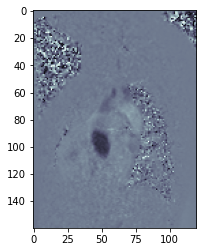

In [13]:
# DICOM tags can be checked here:
# https://www.dicomstandard.org/current
# e.g. in http://dicom.nema.org/medical/dicom/current/output/html/part03.html

image_filename = os.path.join(base_dir, *image_record.ReferencedFileID)
dicom_img = pydicom.dcmread(image_filename)
print("*** SINGLE IMAGE FILE ***")
print("Image filename: {}".format(image_filename))
pprint(dicom_img)
import matplotlib.pyplot as plt
plt.imshow(dicom_img.pixel_array, cmap=plt.cm.get_cmap('bone'))
plt.show()

# Exploratory data analysis with Pandas

### Import pickled DataFrames

In [11]:
from glob import glob
import os

pkls = sorted(glob("/home/lukasd/src/hpc-predict/data/v0/input_data/preprocessed/mri/MRT Daten Bern DICOM Header/3.pkl"), key=lambda x: int(os.path.basename(x).split('.')[0]) )
pkls

['/home/lukasd/src/hpc-predict/data/v0/input_data/preprocessed/mri/MRT Daten Bern DICOM Header/3.pkl']

In [12]:
import pydicom
import pandas as pd
import numpy as np
from pprint import pprint

# Read pandas DataFrame that contains pydicom DataElement entries and was generated with convert_dicom_to_pandas.py
df = pd.concat([pd.read_pickle(pkl) for pkl in pkls],axis=0)
df

(0008, 0005)  \
0     (0008, 0005) Specific Character Set           ...   
1     (0008, 0005) Specific Character Set           ...   
2     (0008, 0005) Specific Character Set           ...   
3     (0008, 0005) Specific Character Set           ...   
4     (0008, 0005) Specific Character Set           ...   
...                                                 ...   
5567  (0008, 0005) Specific Character Set           ...   
5568  (0008, 0005) Specific Character Set           ...   
5569  (0008, 0005) Specific Character Set           ...   
5570  (0008, 0005) Specific Character Set           ...   
5571  (0008, 0005) Specific Character Set           ...   

                                           (0008, 0008)  \
0     (0008, 0008) Image Type                       ...   
1     (0008, 0008) Image Type                       ...   
2     (0008, 0008) Image Type                       ...   
3     (0008, 0008) Image Type                       ...   
4     (0008, 0008) Image Type                       ...   
...                                                 ...   
5567  (0008, 0008) Image Type                       ...   
5568  (0008, 0008) Image Type                       ...   
5569  (0008, 0008) Image Type                       ...   
5570  (0008, 0008) Image Type                       ...   
5571  (0008, 0008) Image Type                       ...   

                                           (0008, 0012)  \
0     (0008, 0012) Instance Creation Date           ...   
1     (0008, 0012) Instance Creation Date           ...   
2     (0008, 0012) Instance Creation Date           ...   
3     (0008, 0012) Instance Creation Date           ...   
4     (0008, 0012) Instance Creation Date           ...   
...                                                 ...   
5567  (0008, 0012) Instance Creation Date           ...   
5568  (0008, 0012) Instance Creation Date           ...   
5569  (0008, 0012) Instance Creation Date           ...   
5570  (0008, 0012) Instance Creation Date           ...   
5571  (0008, 0012) Instance Creation Date           ...   

                                           (0008, 0013)  \
0     (0008, 0013) Instance Creation Time           ...   
1     (0008, 0013) Instance Creation Time           ...   
2     (0008, 0013) Instance Creation Time           ...   
3     (0008, 0013) Instance Creation Time           ...   
4     (0008, 0013) Instance Creation Time           ...   
...                                                 ...   
5567  (0008, 0013) Instance Creation Time           ...   
5568  (0008, 0013) Instance Creation Time           ...   
5569  (0008, 0013) Instance Creation Time           ...   
5570  (0008, 0013) Instance Creation Time           ...   
5571  (0008, 0013) Instance Creation Time           ...   

                                           (0008, 0016)  \
0     (0008, 0016) SOP Class UID                    ...   
1     (0008, 0016) SOP Class UID                    ...   
2     (0008, 0016) SOP Class UID                    ...   
3     (0008, 0016) SOP Class UID                    ...   
4     (0008, 0016) SOP Class UID                    ...   
...                                                 ...   
5567  (0008, 0016) SOP Class UID                    ...   
5568  (0008, 0016) SOP Class UID                    ...   
5569  (0008, 0016) SOP Class UID                    ...   
5570  (0008, 0016) SOP Class UID                    ...   
5571  (0008, 0016) SOP Class UID                    ...   

                                           (0008, 0018)  \
0     (0008, 0018) SOP Instance UID                 ...   
1     (0008, 0018) SOP Instance UID                 ...   
2     (0008, 0018) SOP Instance UID                 ...   
3     (0008, 0018) SOP Instance UID                 ...   
4     (0008, 0018) SOP Instance UID                 ...   
...                                                 ...   
5567  (0008, 0018) SOP Instance UID                 ...   
5568  (0008, 0018) SOP Ins

### Use names instead of DICOM tags as column labels

In [13]:
## Compute the DICOM tag -> name mapping
tag_names = df.apply( lambda c: c.dropna().apply(lambda x: x.name).unique(), axis=0).loc[0] 
#tag_names.to_dict()

In [14]:
df_renamed = df.rename(columns=tag_names.to_dict())

# display only values
pd.set_option('display.max_columns', 20)
df_renamed.applymap(lambda x: x.value if pd.notnull(x) else x )

Specific Character Set                     Image Type  \
0                ISO_IR 100            [ORIGINAL, PRIMARY]   
1                ISO_IR 100            [ORIGINAL, PRIMARY]   
2                ISO_IR 100            [ORIGINAL, PRIMARY]   
3                ISO_IR 100            [ORIGINAL, PRIMARY]   
4                ISO_IR 100            [ORIGINAL, PRIMARY]   
...                     ...                            ...   
5567             ISO_IR 100  [ORIGINAL, PRIMARY, P, DIS2D]   
5568             ISO_IR 100  [ORIGINAL, PRIMARY, P, DIS2D]   
5569             ISO_IR 100  [ORIGINAL, PRIMARY, P, DIS2D]   
5570             ISO_IR 100  [ORIGINAL, PRIMARY, P, DIS2D]   
5571             ISO_IR 100  [ORIGINAL, PRIMARY, P, DIS2D]   

     Instance Creation Date Instance Creation Time              SOP Class UID  \
0                  20110625             182705.250  1.2.840.10008.5.1.4.1.1.4   
1                  20110625             182705.281  1.2.840.10008.5.1.4.1.1.4   
2                  20110625             183405.234  1.2.840.10008.5.1.4.1.1.4   
3                  20110625             182705.265  1.2.840.10008.5.1.4.1.1.4   
4                  20110625             183405.281  1.2.840.10008.5.1.4.1.1.4   
...                     ...                    ...                        ...   
5567               20090323             171432.828  1.2.840.10008.5.1.4.1.1.4   
5568               20090323             171409.531  1.2.840.10008.5.1.4.1.1.4   
5569               20090323             171419.421  1.2.840.10008.5.1.4.1.1.4   
5570               20090323             171423.968  1.2.840.10008.5.1.4.1.1.4   
5571               20090323             171351.515  1.2.840.10008.5.1.4.1.1.4   

                                       SOP Instance UID Study Date  \
0     1.2.40.0.13.1.18217426757998275037614733832236...   20110625   
1     1.2.40.0.13.1.20452092643374306756386350109540...   20110625   
2     1.2.40.0.13.1.15479401915262115973399514975196...   20110625   
3     1.2.40.0.13.1.25697292688449655338696274200789...   20110625   
4     1.2.40.0.13.1.26643637538516871539873548542368...   20110625   
...                                                 ...        ...   
5567  1.2.40.0.13.1.98519309881565925576130969305884...   20090323   
5568  1.2.40.0.13.1.28005958063928916554994256969008...   20090323   
5569  1.2.40.0.13.1.42898990129133471596298092676719...   20090323   
5570  1.2.40.0.13.1.59488720043191463322755114295608...   20090323   
5571  1.2.40.0.13.1.33053610940792777302602062019631...   20090323   

     Series Date Content Date  Study Time  ... Acquisition Date  \
0       20110625     20110625  175702.234  ...              NaN   
1       20110625     20110625  175702.234  ...              NaN   
2       20110625     20110625  175702.234  ...              NaN   
3       20110625     20110625  175702.234  ...              NaN   
4       20110625     20110625  175702.234  ...              NaN   
...          ...          ...         ...  ...              ...   
5567    20090323     20090323  162952.234  ...         20090323   
5568    20090323     20090323  162952.234  ...         20090323   
5569    20090323     20090323  162952.234  ...         20090323   
5570    20090323     20090323  162952.234  ...         20090323   
5571    20090323     20090323  162952.234  ...         20090323   

     Number of Averages Number of Phase Encoding Steps Percent Sampling  \
0                   NaN                            NaN              NaN   
1                   NaN                            NaN              NaN   
2                   NaN                            NaN              NaN   
3                   NaN                            NaN              NaN   
4                   NaN                            NaN              NaN   
...                 ...                            ...              ...   
5567                1.0                          100.0          83.3333   
5568                1.0                  

### Determine range of DICOM tags (via unique rows, grouped by patient ID > study UID > series UID)

In [15]:
# Determine types of DataElement.value entries
from collections import namedtuple, OrderedDict
from types import SimpleNamespace
import json

VrVt = namedtuple('VrVt', ['VR', 'VT'])

pd.set_option('display.max_columns', None)
pd.concat([pd.Series(name=name, data=col.dropna().unique()) for (name, col) in df_renamed.applymap(lambda x: VrVt(x.VR, type(x.value)) if pd.notnull(x) else x).iteritems()], axis=1)

#pd.concat([pd.Series(name=name, data=col.dropna().apply(lambda x: json.dumps(vars(x.value)) if isinstance(x,SimpleNamespace) else json.dumps(x.value)).unique()) for (name, col) in df_renamed.iteritems()], axis=1)


Specific Character Set                                   Image Type  \
0    (CS, <class 'str'>)  (CS, <class 'pydicom.multival.MultiValue'>)   
1                    NaN                                          NaN   

                Instance Creation Date               Instance Creation Time  \
0  (DA, <class 'pydicom.valuerep.DA'>)  (TM, <class 'pydicom.valuerep.TM'>)   
1                                  NaN                                  NaN   

                     SOP Class UID                 SOP Instance UID  \
0  (UI, <class 'pydicom.uid.UID'>)  (UI, <class 'pydicom.uid.UID'>)   
1                              NaN                              NaN   

                            Study Date                          Series Date  \
0  (DA, <class 'pydicom.valuerep.DA'>)  (DA, <class 'pydicom.valuerep.DA'>)   
1                                  NaN                                  NaN   

                          Content Date                           Study Time  \
0  (DA, <class 'pydicom.valuerep.DA'>)  (TM, <class 'pydicom.valuerep.TM'>)   
1                                  NaN                                  NaN   

                           Series Time                     Acquisition Time  \
0  (TM, <class 'pydicom.valuerep.TM'>)  (TM, <class 'pydicom.valuerep.TM'>)   
1                                  NaN                                  NaN   

                          Content Time     Accession Number  \
0  (TM, <class 'pydicom.valuerep.TM'>)  (SH, <class 'str'>)   
1                                  NaN                  NaN   

  Issuer of Accession Number Sequence             Modality  \
0                (SQ, <class 'list'>)  (CS, <class 'str'>)   
1                                 NaN                  NaN   

          Manufacturer Referring Physician's Name Procedure Code Sequence  \
0  (LO, <class 'str'>)        (PN, <class 'str'>)    (SQ, <class 'list'>)   
1                  NaN                        NaN                     NaN   

  Performing Physician's Name                              Operators' Name  \
0         (PN, <class 'str'>)  (PN, <class 'pydicom.valuerep.PersonName'>)   
1                         NaN                                          NaN   

  Admitting Diagnoses Description Manufacturer's Model Name  \
0             (LO, <class 'str'>)       (LO, <class 'str'>)   
1                             NaN                       NaN   

  Referenced Image Sequence Derivation Code Sequence  \
0      (SQ, <class 'list'>)     (SQ, <class 'list'>)   
1                       NaN                      NaN   

                                Patient's Name           Patient ID  \
0  (PN, <class 'pydicom.valuerep.PersonName'>)  (LO, <class 'str'>)   
1                                          NaN                  NaN   

  Patient's Birth Date        Patient's Sex  Other Patient Names  \
0  (DA, <class 'str'>)  (CS, <class 'str'>)  (PN, <class 'str'>)   
1                  NaN                  NaN                  NaN   

         Patient's Age                            Patient's Size  \
0  (AS, <class 'str'>)  (DS, <class 'pydicom.valuerep.DSfloat'>)   
1                  NaN                                       NaN   

                           Patient's Weight Patient Identity Removed  \
0  (DS, <class 'pydicom.valuerep.DSfloat'>)      (CS, <class 'str'>)   
1                                       NaN                      NaN   

  De-identification Method Code Sequence    Scanning Sequence  \
0                   (SQ, <class 'list'>)  (CS, <class 'str'>)   
1                                    NaN                  NaN   

                              Sequence Variant         Scan Options  \
0  (CS, <class 'pydicom.multival.MultiValue'>)  (CS, <class 'str'>)   
1                                          NaN                  NaN   

   MR Acquisition Type        Sequence Name           Angio Flag  \
0  (CS, <class 'str'>)  (SH, <class 'str'>)  (CS, <class 'str'>)   
1                  NaN    

In [12]:
# Extract built-in/standard python datatypes from pydicom DataElements

def get_builtin_from_pydicom(val):
    from pydicom.valuerep import DA, DT, TM, DSfloat, DSdecimal, IS, PersonName
    from pydicom.uid import UID
    from pydicom.multival import MultiValue
    from datetime import (date, datetime, time, timedelta, timezone)
    from decimal import Decimal

    if isinstance(val, DA):
        return date(val.year, val.month, val.day)
    elif isinstance(val, DT):
        return datetime(val.year, val.month, val.day,
                        val.hour, val.minute, val.second,
                        val.microsecond, val.tzinfo)
    elif isinstance(val, TM):
        return time(val.hour, val.minute, val.second,
                    val.microsecond)
    elif isinstance(val, DSfloat):
        return float(val)
    elif isinstance(val, DSdecimal):
        return Decimal(val)
    elif isinstance(val, IS):
        return int(val)
    elif isinstance(val, MultiValue):
        return tuple([get_builtin_from_pydicom(el) for el in val])
    elif isinstance(val, UID):
        return str(val)
    elif isinstance(val, (PersonName, str, int, float)):
        return val
    elif isinstance(val, list):
        return tuple(val)
    else:
        return val
    
# pydicom_tuples = dict()

# def get_vars_pydicom(value):
#     from pydicom.valuerep import DSfloat, DA, DT, TM
#     from pydicom.uid import UID
#     from datetime import date, time
    
#     if isinstance(value, DSfloat):
#         return value.__getstate__()
#     elif isinstance(value, UID):
#         return {'uid': str(value)}
#     elif isinstance(value, DA) or isinstance(value, DT) or isinstance(value, TM):
#         return {'original_string': value.original_string}
#     else:
#         return vars(value)
        

def hashify_pydicom(value):
    if hasattr(type(value),'__module__') and type(value).__module__.startswith('pydicom'):
#         if not type(value) in pydicom_tuples:
#             pydicom_tuples[type(value)] = namedtuple(type(value).__name__,[k.lstrip("_") for k in get_vars_pydicom(value).keys()])
#         return pydicom_tuples[type(value)](**{k.lstrip("_"): hashify_pydicom(v) if not type(v).__module__.endswith('valuerep') else v for (k,v) in get_vars_pydicom(value).items()})
        return get_builtin_from_pydicom(value)
    elif isinstance(value, list):
        return tuple([hashify_pydicom(v) for v in value])
    elif isinstance(value,OrderedDict):
        return tuple( [hashify_pydicom(v.value) for v in value.values()] )
    elif isinstance(value, dict):
        return tuple(value.items())
    else:
        return value
    
def agg_unique(group):
    labels = []
    row = []
    for (name, col) in group[group.columns[:]].iteritems():
        labels.append(name)
        row.append(col.dropna().unique())

    return pd.DataFrame([row], columns=labels)

In [17]:
#df_renamed_hashified = df_renamed.applymap(lambda x: type(hashify_pydicom(x.value)) if pd.notnull(x) else x)
#df_renamed_hashified.drop_duplicates()
df_renamed_hashified = df_renamed.applymap(lambda x: hashify_pydicom(x.value) if pd.notnull(x) else x)

group_by_series_keys = ['FileCollectionID', 'Instance Creation Date', 'Patient ID', 'Study Instance UID', 'Sequence Name', 'Series Instance UID', 'Image Type']
df_grouped = df_renamed_hashified.groupby(group_by_series_keys)
df_grouped_unique = df_grouped.apply(lambda x: agg_unique(x))   # 


# labels = []
# row = []
# for (name, col) in df_renamed[df_renamed.columns[:]].iteritems(): # df_renamed.columns[:60]
#     labels.append(name)
#     print(name)
#     row.append(col.dropna().apply(lambda x: hashify_pydicom(x.value)).unique())
#     print(row[-1])

# pd.DataFrame([row], columns=labels)


In [18]:
#df_renamed.columns.to_list()

In [19]:
#df_renamed['Issuer of Accession Number Sequence'][0].value[0].values()

In [23]:
# Display all tags with <= 1 unique values per series in any series

df_grouped_unique.drop(df_grouped_unique.columns[df_grouped_unique.applymap(lambda x: len(x) > 1).any()],axis=1).applymap(lambda x: x[0] if len(x) == 1 else x)

Specific Character Set  \
FileCollectionID Instance Creation Date Patient ID    Study Instance UID                                 Sequence Name Series Instance UID                                Image Type                                     
3                2009-03-23             ANONYM-REVX4  1.2.40.0.13.1.237828120959059386345548749032058... fl3d1         1.2.40.0.13.1.213723252275640155219987317546234... (ORIGINAL, PRIMARY) 0             ISO_IR 100   
                                                                                                                       1.2.40.0.13.1.250363090365366252242767248776958... (ORIGINAL, PRIMARY) 0             ISO_IR 100   
                 2011-06-25             ANONYM-KBPD3B 1.2.40.0.13.1.336917043524843706258805057826430... Nav           1.2.40.0.13.1.198221003098392982073940324396728... (ORIGINAL, PRIMARY) 0             ISO_IR 100   
                                                                                                                       1.2.40.0.13.1.770352726346319058413031399208273... (ORIGINAL, PRIMARY) 0             ISO_IR 100   
                                                                                                         fl3d1         1.2.40.0.13.1.664971475135209300836943690831909... (ORIGINAL, PRIMARY) 0             ISO_IR 100   
                                                                                                                       1.2.40.0.13.1.790954445771044222540324665337371... (ORIGINAL, PRIMARY) 0             ISO_IR 100   

                                                                                                                                                                                                                    Image Type  \
FileCollectionID Instance Creation Date Patient ID    Study Instance UID                                 Sequence Name Series Instance UID                                Image Type                                             
3                2009-03-23             ANONYM-REVX4  1.2.40.0.13.1.237828120959059386345548749032058... fl3d1         1.2.40.0.13.1.213723252275640155219987317546234... (ORIGINAL, PRIMARY) 0  (ORIGINAL, PRIMARY, M, DIS2D)   
                                                                                                                       1.2.40.0.13.1.250363090365366252242767248776958... (ORIGINAL, PRIMARY) 0  (ORIGINAL, PRIMARY, P, DIS2D)   
                 2011-06-25             ANONYM-KBPD3B 1.2.40.0.13.1.336917043524843706258805057826430... Nav           1.2.40.0.13.1.198221003098392982073940324396728... (ORIGINAL, PRIMARY) 0            (ORIGINAL, PRIMARY)   
                                                                                                                       1.2.40.0.13.1.770352726346319058413031399208273... (ORIGINAL, PRIMARY) 0            (ORIGINAL, PRIMARY)   
                                                                                                         fl3d1         1.2.40.0.13.1.664971475135209300836943690831909... (ORIGINAL, PRIMARY) 0  (ORIGINAL, PRIMARY, M, DIS2D)   
                                                                                                                       1.2.40.0.13.1.790954445771044222540324665337371... (ORIGINAL, PRIMARY) 0  (ORIGINAL, PRIMARY, P, DIS2D)   

                                                                                                                                                                                                Instance Creation Date  \
FileCollectionID Instance Creation Date Patient ID    Study Instance UID                                 Sequence Name Series Instance UID                                Image Type                                     
3                2009-03-23             ANONYM-REVX4  1.2.40.0.13.1.237828120959059386345548749032058... fl3d1         1.2.40.0.13.1.213723252275640155219987317546234... (ORIGINAL, PRIMARY) 0           

In [24]:
#list(df_grouped_unique['De-identification Method Code Sequence'])

In [25]:
df_grouped_unique.drop(df_grouped_unique.columns[df_grouped_unique.applymap(lambda x: len(x) <= 1).all()],axis=1).applymap(lambda x: len(x))

Instance Creation Time  \
FileCollectionID Instance Creation Date Patient ID    Study Instance UID                                 Sequence Name Series Instance UID                                Image Type                                      
3                2009-03-23             ANONYM-REVX4  1.2.40.0.13.1.237828120959059386345548749032058... fl3d1         1.2.40.0.13.1.213723252275640155219987317546234... (ORIGINAL, PRIMARY) 0                     140   
                                                                                                                       1.2.40.0.13.1.250363090365366252242767248776958... (ORIGINAL, PRIMARY) 0                     447   
                 2011-06-25             ANONYM-KBPD3B 1.2.40.0.13.1.336917043524843706258805057826430... Nav           1.2.40.0.13.1.198221003098392982073940324396728... (ORIGINAL, PRIMARY) 0                      10   
                                                                                                                       1.2.40.0.13.1.770352726346319058413031399208273... (ORIGINAL, PRIMARY) 0                       1   
                                                                                                         fl3d1         1.2.40.0.13.1.664971475135209300836943690831909... (ORIGINAL, PRIMARY) 0                     140   
                                                                                                                       1.2.40.0.13.1.790954445771044222540324665337371... (ORIGINAL, PRIMARY) 0                     447   

                                                                                                                                                                                                 SOP Instance UID  \
FileCollectionID Instance Creation Date Patient ID    Study Instance UID                                 Sequence Name Series Instance UID                                Image Type                                
3                2009-03-23             ANONYM-REVX4  1.2.40.0.13.1.237828120959059386345548749032058... fl3d1         1.2.40.0.13.1.213723252275640155219987317546234... (ORIGINAL, PRIMARY) 0               690   
                                                                                                                       1.2.40.0.13.1.250363090365366252242767248776958... (ORIGINAL, PRIMARY) 0              2070   
                 2011-06-25             ANONYM-KBPD3B 1.2.40.0.13.1.336917043524843706258805057826430... Nav           1.2.40.0.13.1.198221003098392982073940324396728... (ORIGINAL, PRIMARY) 0                51   
                                                                                                                       1.2.40.0.13.1.770352726346319058413031399208273... (ORIGINAL, PRIMARY) 0                 1   
                                                                                                         fl3d1         1.2.40.0.13.1.664971475135209300836943690831909... (ORIGINAL, PRIMARY) 0               690   
                                                                                                                       1.2.40.0.13.1.790954445771044222540324665337371... (ORIGINAL, PRIMARY) 0              2070   

                                                                                                                                                                                                 Acquisition Time  \
FileCollectionID Instance Creation Date Patient ID    Study Instance UID                                 Sequence Name Series Instance UID                                Image Type                                
3                2009-03-23             ANONYM-REVX4  1.2.40.0.13.1.237828120959059386345548749032058... fl3d1         1.2.40.0.13.1.213723252275640155219987317546234... (ORIGINAL, PRIMARY) 0                23   
                                                                                                

In [26]:
# Display all tags with > 15 unique values in at least one series

df_grouped_unique.drop(df_grouped_unique.columns[df_grouped_unique.applymap(lambda x: len(x) <= 1).all()],axis=1).applymap(lambda x: x[0] if len(x) == 1 else x).drop(['FilePath'], axis=1)

## Same principle can be applied on original data frame
#df_unique = df_renamed_hashified.pipe(agg_unique)
#df_unique.applymap(lambda x: len(x) < 15).all()

Instance Creation Time  \
FileCollectionID Instance Creation Date Patient ID    Study Instance UID                                 Sequence Name Series Instance UID                                Image Type                                                                 
3                2009-03-23             ANONYM-REVX4  1.2.40.0.13.1.237828120959059386345548749032058... fl3d1         1.2.40.0.13.1.213723252275640155219987317546234... (ORIGINAL, PRIMARY) 0  [17:13:56.906000, 17:14:33.875000, 17:14:20.31...   
                                                                                                                       1.2.40.0.13.1.250363090365366252242767248776958... (ORIGINAL, PRIMARY) 0  [17:14:32.703000, 17:14:23.515000, 17:14:01.01...   
                 2011-06-25             ANONYM-KBPD3B 1.2.40.0.13.1.336917043524843706258805057826430... Nav           1.2.40.0.13.1.198221003098392982073940324396728... (ORIGINAL, PRIMARY) 0  [18:27:05.250000, 18:27:05.281000, 18:34:05.23...   
                                                                                                                       1.2.40.0.13.1.770352726346319058413031399208273... (ORIGINAL, PRIMARY) 0                                    18:20:49.265000   
                                                                                                         fl3d1         1.2.40.0.13.1.664971475135209300836943690831909... (ORIGINAL, PRIMARY) 0  [18:41:38.671000, 18:41:01.921000, 18:41:20.34...   
                                                                                                                       1.2.40.0.13.1.790954445771044222540324665337371... (ORIGINAL, PRIMARY) 0  [18:41:01.640000, 18:41:01.609000, 18:41:10.90...   

                                                                                                                                                                                                                                  SOP Instance UID  \
FileCollectionID Instance Creation Date Patient ID    Study Instance UID                                 Sequence Name Series Instance UID                                Image Type                                                                 
3                2009-03-23             ANONYM-REVX4  1.2.40.0.13.1.237828120959059386345548749032058... fl3d1         1.2.40.0.13.1.213723252275640155219987317546234... (ORIGINAL, PRIMARY) 0  [1.2.40.0.13.1.2850948504992171369129582686636...   
                                                                                                                       1.2.40.0.13.1.250363090365366252242767248776958... (ORIGINAL, PRIMARY) 0  [1.2.40.0.13.1.2993180015541081390121144076683...   
                 2011-06-25             ANONYM-KBPD3B 1.2.40.0.13.1.336917043524843706258805057826430... Nav           1.2.40.0.13.1.198221003098392982073940324396728... (ORIGINAL, PRIMARY) 0  [1.2.40.0.13.1.1821742675799827503761473383223...   
                                                                                                                       1.2.40.0.13.1.770352726346319058413031399208273... (ORIGINAL, PRIMARY) 0  1.2.40.0.13.1.29988059599668182801403313758757...   
                                                                                                         fl3d1         1.2.40.0.13.1.664971475135209300836943690831909... (ORIGINAL, PRIMARY) 0  [1.2.40.0.13.1.1140388632954378348651686387015...   
                                                                                                                       1.2.40.0.13.1.790954445771044222540324665337371... (ORIGINAL, PRIMARY) 0  [1.2.40.0.13.1.1353337156283215410728836450690...   

                                                                                                                                                                                                                                  Acquisition Time  \
FileCollectionID Instance Creation D

### Analysis: Referenced Image Sequence tag

In [27]:
example_referenced_uid = df_renamed_hashified['Referenced Image Sequence'].iloc[0][0][1]

# Check if we can find the referenced image sequence
print("The string length of a Referenced Image Sequence UID is {}.".format(len(example_referenced_uid)))
for i in df_renamed_hashified['SOP Instance UID']: #.apply(lambda c: c.uid):
    if i.startswith(example_referenced_uid[:18]):
        print(i)

The string length of a Referenced Image Sequence UID is 53.
1.2.40.0.13.1.200614003532225211510116652275555825370
1.2.40.0.13.1.200603853488920732770922219193456776981


Conclusion: Matches for Referenced Image Sequence Tag only work for very short prefixes - in general unable to resolve these UID references.

### Analysis: Acquisition time, Content time, Trigger time and Nominal interval

In [28]:
import matplotlib.pyplot as plt

In [29]:
%matplotlib inline

In [30]:
plt.rcParams.update({'font.size': 14})

In [31]:
import datetime  
from types import SimpleNamespace

In [32]:
type(df_renamed_hashified['Nominal Interval'][0])

numpy.int64

In [33]:
group_by_series_title = "Group by series UID plot (" + \
                        " / ".join([group_by_series_keys[0],
                                    group_by_series_keys[1],
                                    group_by_series_keys[4],
                                    group_by_series_keys[6],
                                    'Nominal Interval',
                                    'Cardiac Number of Images',
                                    '[P-index]'
                                  ]) + \
                        ")"

def legend_unique_values(ls):
    return str(ls[0]) if len(ls)==1 else "{}..{}".format(ls.min(), ls.max()) 

def group_by_series_legend(name, group, j=None):
    nominal_intervals = group['Nominal Interval'].unique() #.apply(lambda x: x.original_string).unique()
    cardiac_number_of_images = group['Cardiac Number of Images'].unique() #.apply(lambda x: x.original_string).unique()
#     return ", ".join([
#             str(name[0]), 
#             "{}/{}/{}".format(name[1].original_string[:4],name[1].original_string[4:6],name[1].original_string[6:8]),
#             name[6],
#             str(name[5].list), 
#             "NomInt {} ms".format(legend_unique_values(nominal_intervals)),
#             "CardImgs {}".format(legend_unique_values(cardiac_number_of_images))
#             ]) + (", P-{}".format(j) if j is not None else "")
    return ", ".join([
            str(name[0]),
            str(name[1]),
            name[4],
            str(name[6]), 
            "NomInt {} ms".format(legend_unique_values(nominal_intervals)),
            "CardImgs {}".format(legend_unique_values(cardiac_number_of_images))
            ]) + (", P-{}".format(j) if j is not None else "")    

In [34]:
#g = df_renamed_hashified.groupby(group_by_series_keys)
#[group for (_,group) in g][1]['Instance Number'].iloc[0]

In [35]:
#list(g.groups.keys())

In [36]:
#ncols = 3
#nrows = (len(g.groups)+3-1)//ncols

In [37]:
from inspect import signature

# def make_group_by_plot(df, x_series, x_label, y_series, y_label):
def make_group_by_plot(groups, x_series, x_label, y_series, y_label):
    
#     groups = df.\
#         applymap(lambda x: hashify_pydicom(x.value) if pd.notnull(x) else x).\
#         groupby(group_by_series_keys)
    
    ngroups = len(groups.groups)
    ncols = 3
    nrows = (ngroups+3-1)//ncols    
    
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, sharex=True, figsize=(12*ncols,8*nrows))
    ax = ax.flatten()
    
    for i, (name, group) in enumerate(groups): 

#         if 'P' not in group['Image Type'].iloc[0].list:
        if 'P' not in group['Image Type'].iloc[0]:
            ax[i].plot(x_series(group), 
                       y_series(group), 
                       'o',  ms=6, linewidth=1, 
                       label=group_by_series_legend(name,group))
        else:        
            for j in range(3):
#                 select_subgroup = group['Instance Number'].apply(lambda x: j*group.shape[0]//3 < int(x.original_string) and int(x.original_string) <= (j+1)*group.shape[0]//3)            
                select_subgroup = group['Instance Number'].apply(lambda x: j*group.shape[0]//3 < x and x <= (j+1)*group.shape[0]//3)            
                ax[i].plot(x_series(group[select_subgroup]), 
                           y_series(group[select_subgroup]),
                           'o',  ms=6, linewidth=1, 
                           label=group_by_series_legend(name,group,j))

    for a in ax[:ngroups]: 
        a.set_xlabel(x_label)
        a.set_ylabel(y_label)

        a.legend(bbox_to_anchor=(-0.06, 1.04), loc="lower left") #,loc=0)
        a.grid()
    fig.suptitle(group_by_series_title)
    fig.tight_layout(pad=3.)

In [38]:
def acquisition_datetime(df):
    return df.apply(
        lambda x: datetime.datetime(x['Series Date'].year, 
                                    x['Series Date'].month, 
                                    x['Series Date'].day, 
                                    x['Acquisition Time'].hour, 
                                    x['Acquisition Time'].minute,
                                    x['Acquisition Time'].second, 
                                    x['Acquisition Time'].microsecond, 
                                    x['Acquisition Time'].tzinfo ), axis=1)

def acqusition_datetime_offset(df):
    acquisition_datetime_series = acquisition_datetime(df)
    return acquisition_datetime_series - acquisition_datetime_series.min()

# for name, group in df_grouped:
#     (acquisition_datetime_series(group)-acquisition_datetime_series(group).min()).apply(lambda x: x.total_seconds()*1e3)

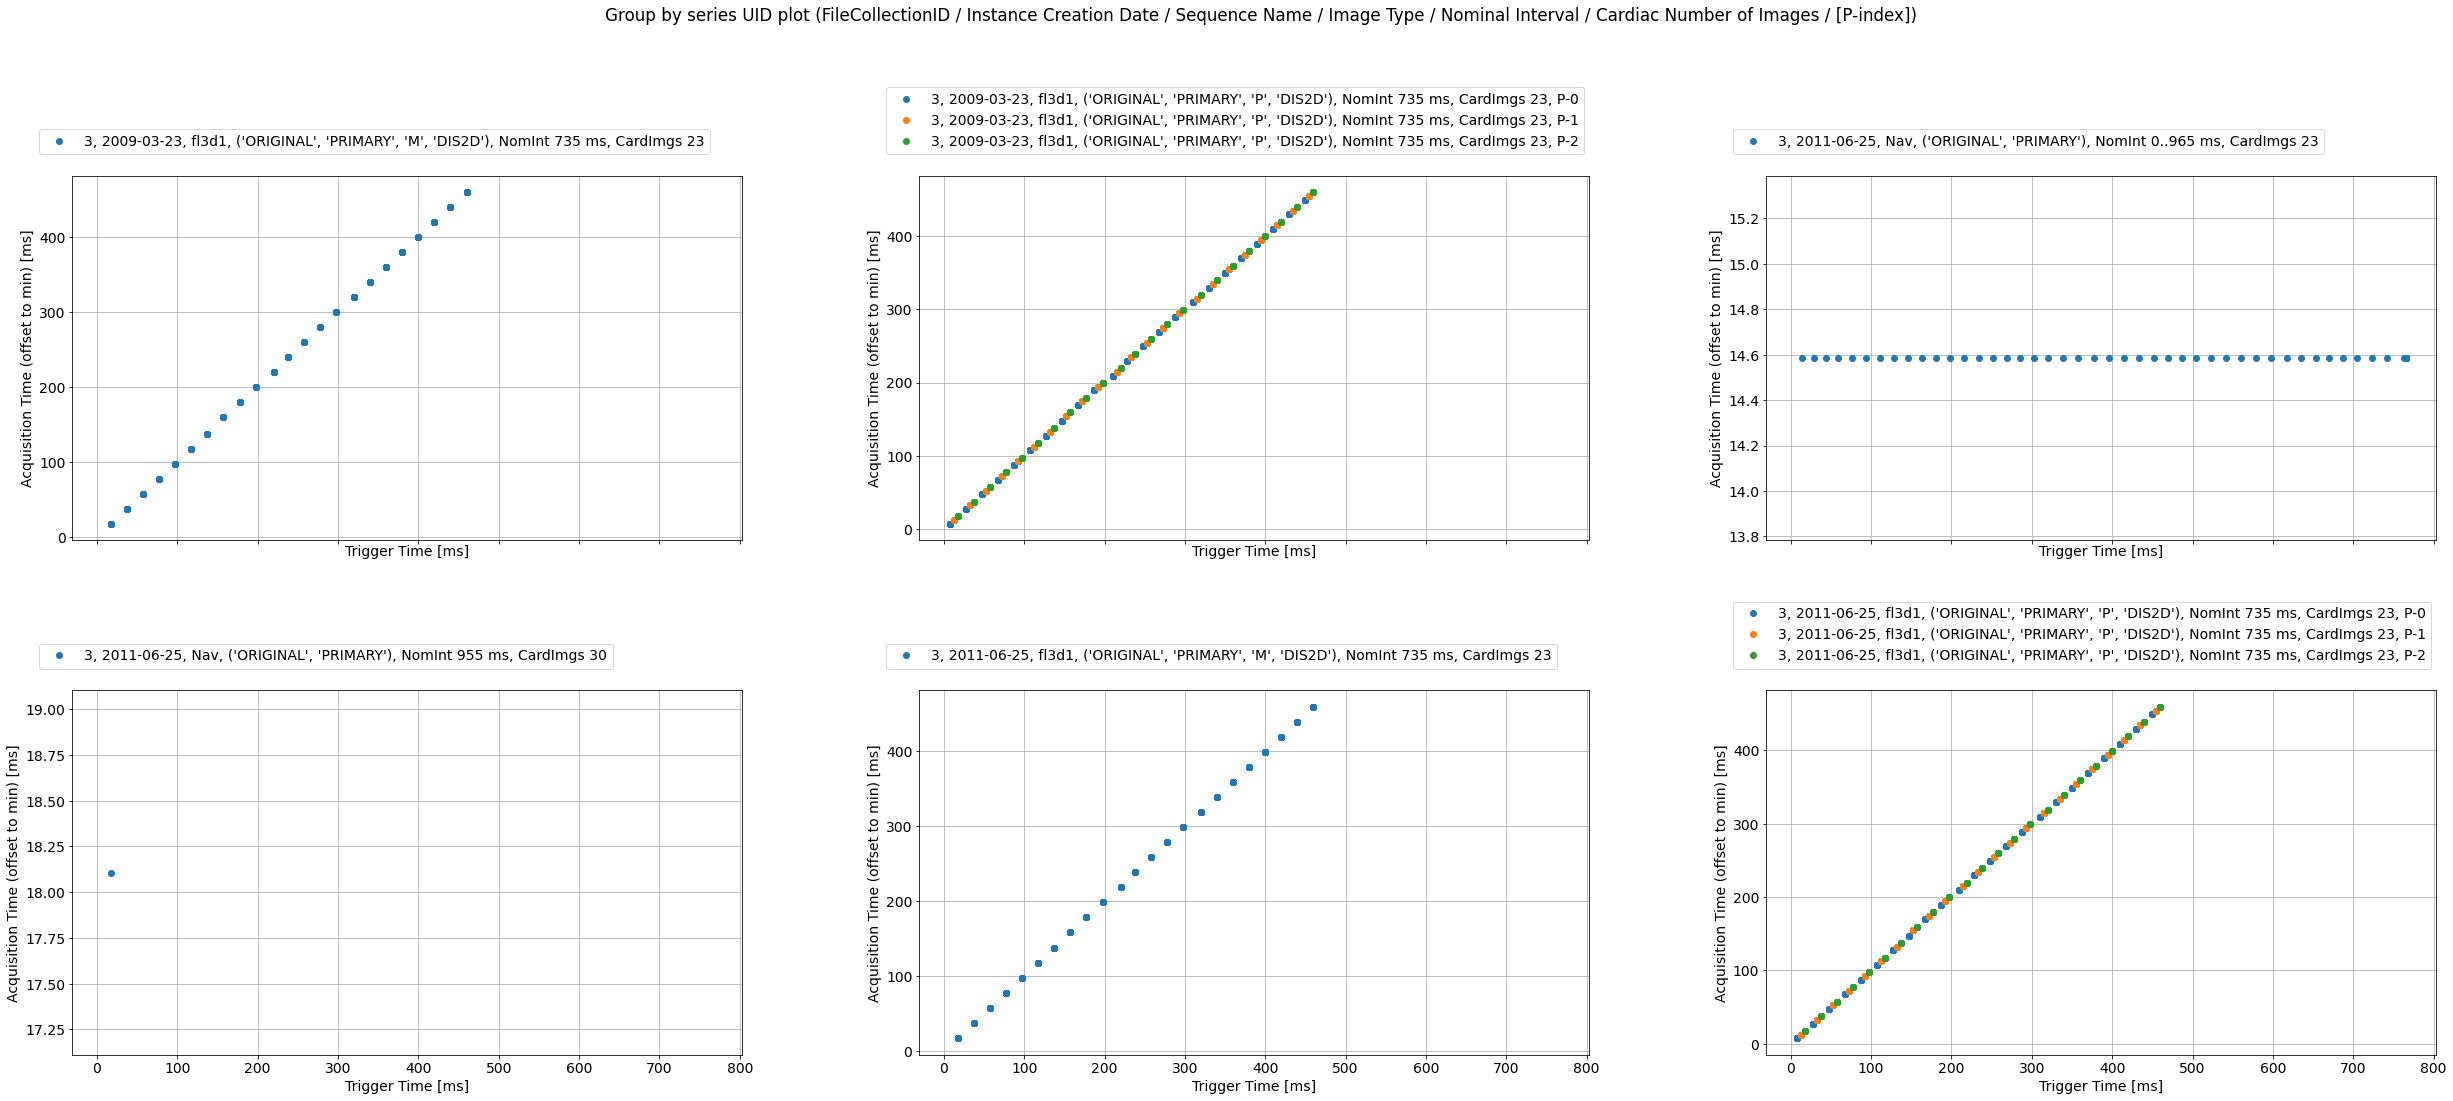

In [39]:
# acquisition_datetime = pd.DataFrame({'Acquisition Datetime': df_renamed.apply(
#     lambda x: datetime.datetime(x['Series Date'].value.year, 
#                                 x['Series Date'].value.month, 
#                                 x['Series Date'].value.day, 
#                                 x['Acquisition Time'].value.hour, 
#                                 x['Acquisition Time'].value.minute,
#                                 x['Acquisition Time'].value.second, 
#                                 x['Acquisition Time'].value.microsecond, 
#                                 x['Acquisition Time'].value.tzinfo ), axis=1 )}).applymap(lambda x: SimpleNamespace(value=x))
# acquisition_datetime = pd.DataFrame({'Acquisition Datetime': df_renamed.apply(
#     lambda x: datetime.datetime(x['Series Date'].year, 
#                                 x['Series Date'].month, 
#                                 x['Series Date'].day, 
#                                 x['Acquisition Time'].hour, 
#                                 x['Acquisition Time'].minute,
#                                 x['Acquisition Time'].second, 
#                                 x['Acquisition Time'].microsecond, 
#                                 x['Acquisition Time'].tzinfo ), axis=1 )}).applymap(lambda x: SimpleNamespace(value=x))
# acquisition_datetime

# group_x_series = lambda group: group['Trigger Time'].apply(lambda x: float(x.original_string))
group_x_series = lambda group: group['Trigger Time']
x_label = 'Trigger Time [ms]'
#group_y_series = lambda group: ((group['Acquisition Datetime']-group['Acquisition Datetime'].min()).apply(lambda x: x.total_seconds()*1e3)+group['Trigger Time'].apply(lambda x: float(x.original_string)).min())
group_y_series = lambda group: acqusition_datetime_offset(group).apply(lambda x: x.total_seconds()*1e3)+group['Trigger Time'].min()
y_label = 'Acquisition Time (offset to min) [ms]'
# make_group_by_plot(pd.concat([df_renamed, acquisition_datetime], axis=1), group_x_series, x_label, group_y_series, y_label)
make_group_by_plot(df_grouped, group_x_series, x_label, group_y_series, y_label)


It seems that the Trigger Time and Acquisition time coincide up to an offset for Acquisition time. Also, they do not cover the entire heart cycle but only a bit more than the first half. This could be the case since it may be a prospective hear MRI as explained [here](http://mriquestions.com/gating-parameters.html).

In [40]:
#pd.concat([df_grouped_unique[['Trigger Time']].applymap(lambda x: np.max([float(e.original_string) for e in x ])), df_grouped_unique[['Nominal Interval']]], axis=1)
pd.concat([df_grouped_unique[['Trigger Time']].applymap(lambda x: np.max(x)), df_grouped_unique[['Nominal Interval']]], axis=1)


Trigger Time  \
FileCollectionID Instance Creation Date Patient ID    Study Instance UID                                 Sequence Name Series Instance UID                                Image Type                            
3                2009-03-23             ANONYM-REVX4  1.2.40.0.13.1.237828120959059386345548749032058... fl3d1         1.2.40.0.13.1.213723252275640155219987317546234... (ORIGINAL, PRIMARY) 0      460.0000   
                                                                                                                       1.2.40.0.13.1.250363090365366252242767248776958... (ORIGINAL, PRIMARY) 0      460.0000   
                 2011-06-25             ANONYM-KBPD3B 1.2.40.0.13.1.336917043524843706258805057826430... Nav           1.2.40.0.13.1.198221003098392982073940324396728... (ORIGINAL, PRIMARY) 0      765.1900   
                                                                                                                       1.2.40.0.13.1.770352726346319058413031399208273... (ORIGINAL, PRIMARY) 0       18.1075   
                                                                                                         fl3d1         1.2.40.0.13.1.664971475135209300836943690831909... (ORIGINAL, PRIMARY) 0      460.0000   
                                                                                                                       1.2.40.0.13.1.790954445771044222540324665337371... (ORIGINAL, PRIMARY) 0      460.0000   

                                                                                                                                                                                                                                  Nominal Interval  
FileCollectionID Instance Creation Date Patient ID    Study Instance UID                                 Sequence Name Series Instance UID                                Image Type                                                                
3                2009-03-23             ANONYM-REVX4  1.2.40.0.13.1.237828120959059386345548749032058... fl3d1         1.2.40.0.13.1.213723252275640155219987317546234... (ORIGINAL, PRIMARY) 0                                              [735]  
                                                                                                                       1.2.40.0.13.1.250363090365366252242767248776958... (ORIGINAL, PRIMARY) 0                                              [735]  
                 2011-06-25             ANONYM-KBPD3B 1.2.40.0.13.1.336917043524843706258805057826430... Nav           1.2.40.0.13.1.198221003098392982073940324396728... (ORIGINAL, PRIMARY) 0  [940, 947, 927, 955, 0, 917, 932, 965, 920, 92...  
                                                                                                                       1.2.40.0.13.1.770352726346319058413031399208273... (ORIGINAL, PRIMARY) 0                                              [955]  
                                                                                                         fl3d1         1.2.40.0.13.1.664971475135209300836943690831909... (ORIGINAL, PRIMARY) 0                                              [735]  
                                                                                                                       1.2.40.0.13.1.790954445771044222540324665337371... (ORIGINAL, PRIMARY) 0                                              [735]

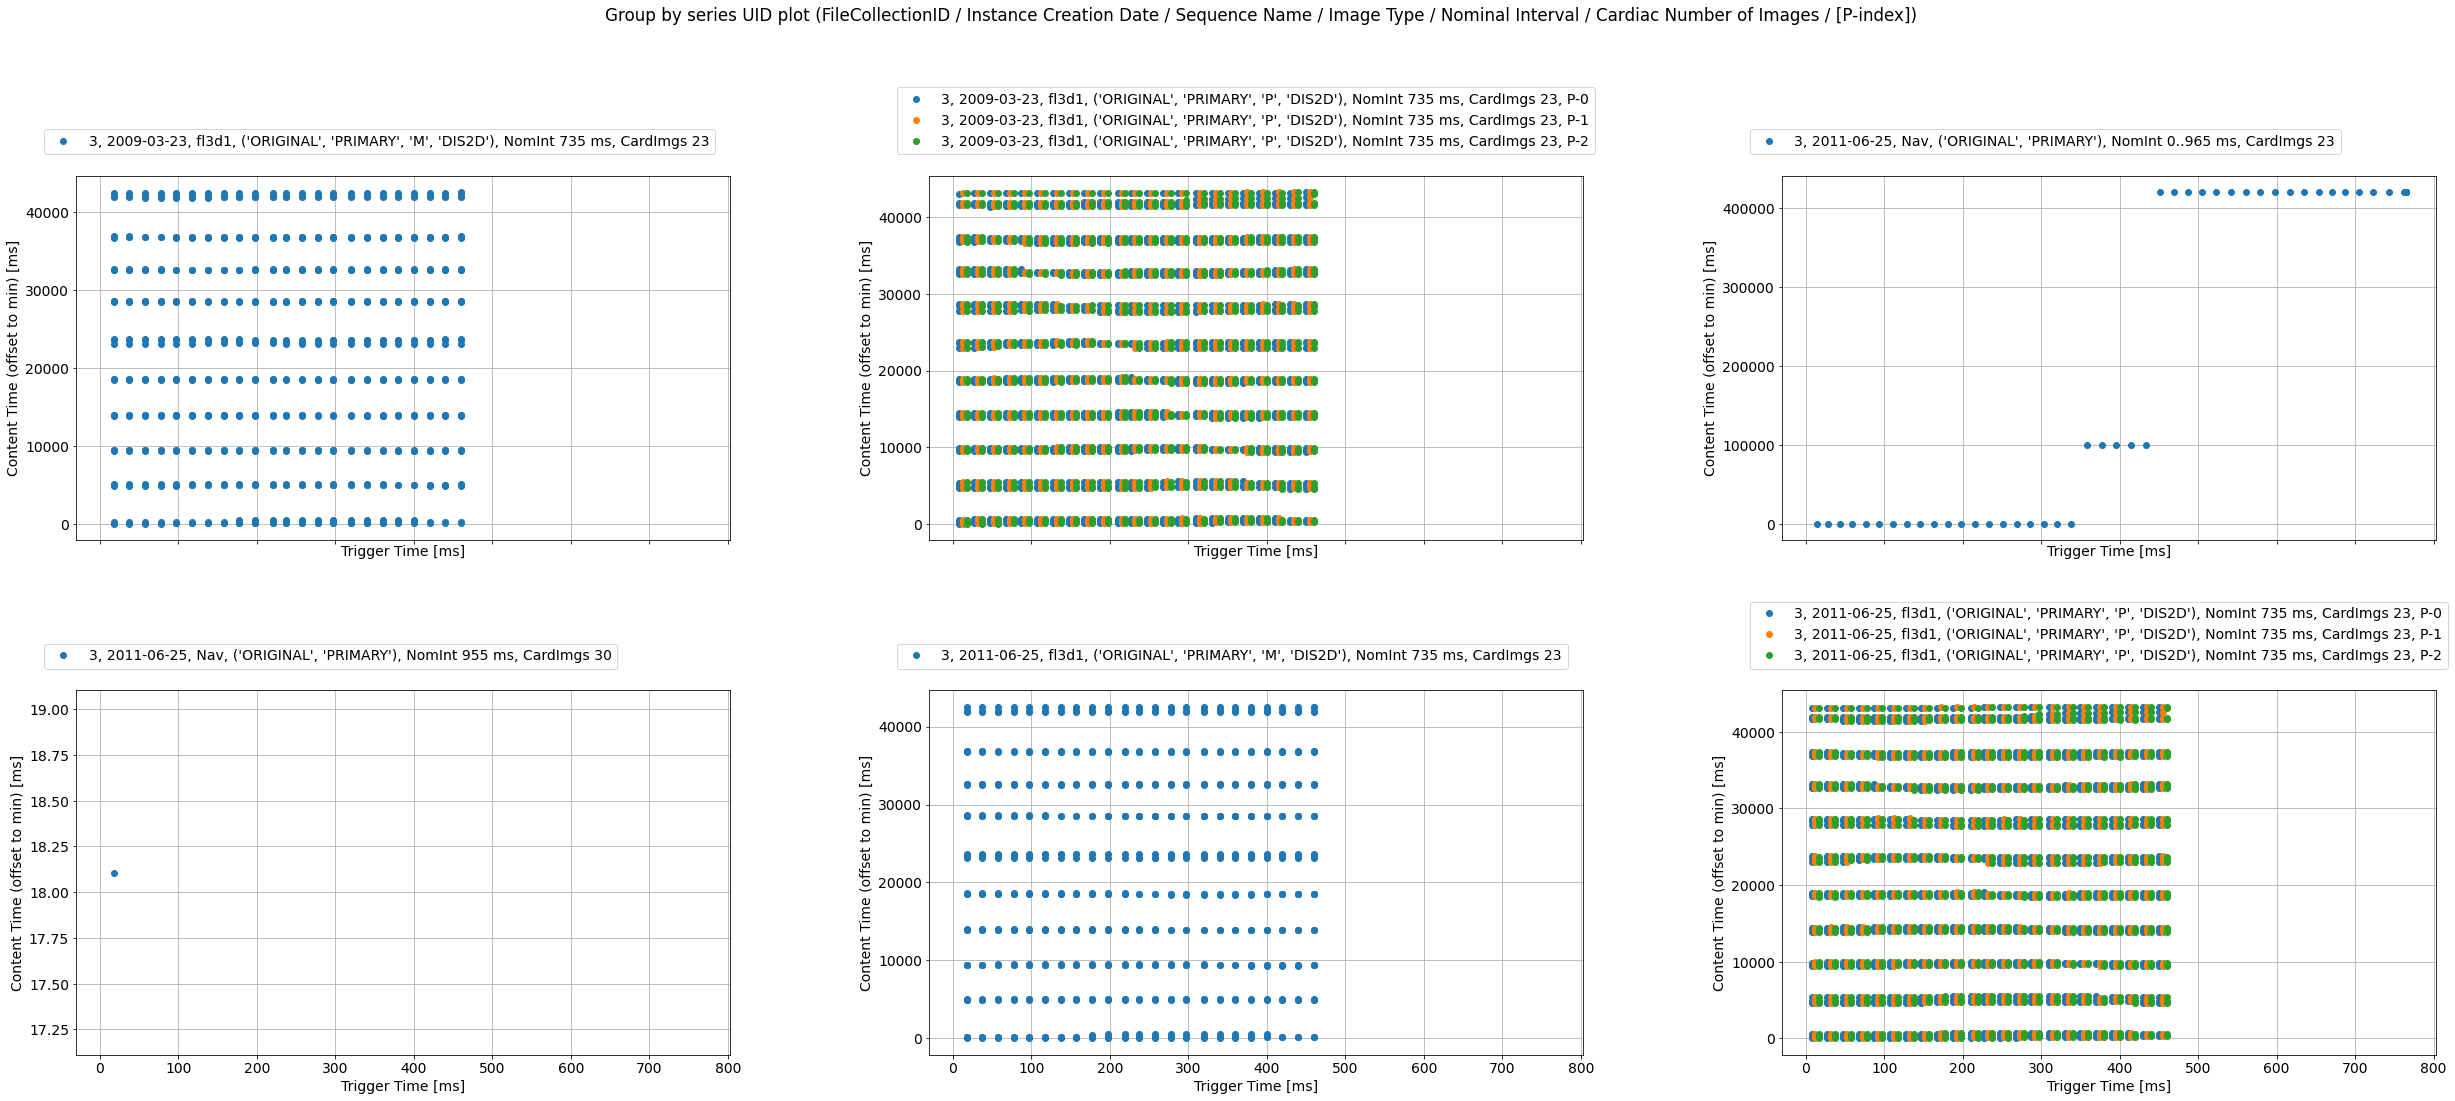

In [41]:
def content_datetime(df):
    return df.apply(
        lambda x: datetime.datetime(x['Series Date'].year, 
                                    x['Series Date'].month, 
                                    x['Series Date'].day, 
                                    x['Content Time'].hour, 
                                    x['Content Time'].minute,
                                    x['Content Time'].second, 
                                    x['Content Time'].microsecond, 
                                    x['Content Time'].tzinfo ), axis=1)

def content_datetime_offset(df):
    content_datetime_series = content_datetime(df)
    return content_datetime_series - content_datetime_series.min()

# content_datetime = pd.DataFrame({'Content Datetime': df_renamed.apply(
#     lambda x: datetime.datetime(x['Series Date'].value.year, 
#                                 x['Series Date'].value.month, 
#                                 x['Series Date'].value.day, 
#                                 x['Content Time'].value.hour, 
#                                 x['Content Time'].value.minute,
#                                 x['Content Time'].value.second, 
#                                 x['Content Time'].value.microsecond, 
#                                 x['Content Time'].value.tzinfo ), axis=1 )}).applymap(lambda x: SimpleNamespace(value=x))
# content_datetime

#group_x_series = lambda group: group['Trigger Time'].apply(lambda x: float(x.original_string))
group_x_series = lambda group: group['Trigger Time']
x_label = 'Trigger Time [ms]'
#group_y_series = lambda group: (group['Content Datetime']-group['Content Datetime'].min()).apply(lambda x: x.total_seconds()*1e3) + group['Trigger Time'].apply(lambda x: float(x.original_string)).min()
group_y_series = lambda group: content_datetime_offset(group).apply(lambda x: x.total_seconds()*1e3)+group['Trigger Time'].min()
y_label = 'Content Time (offset to min) [ms]'
#make_group_by_plot(pd.concat([df_renamed, content_datetime], axis=1), group_x_series, x_label, group_y_series, y_label)
make_group_by_plot(df_grouped, group_x_series, x_label, group_y_series, y_label)


Seems that the Content Time refers to the time when the MRI signal was recorded - the entire sequence is spread over more than 40 seconds. No structure apparent from these plots

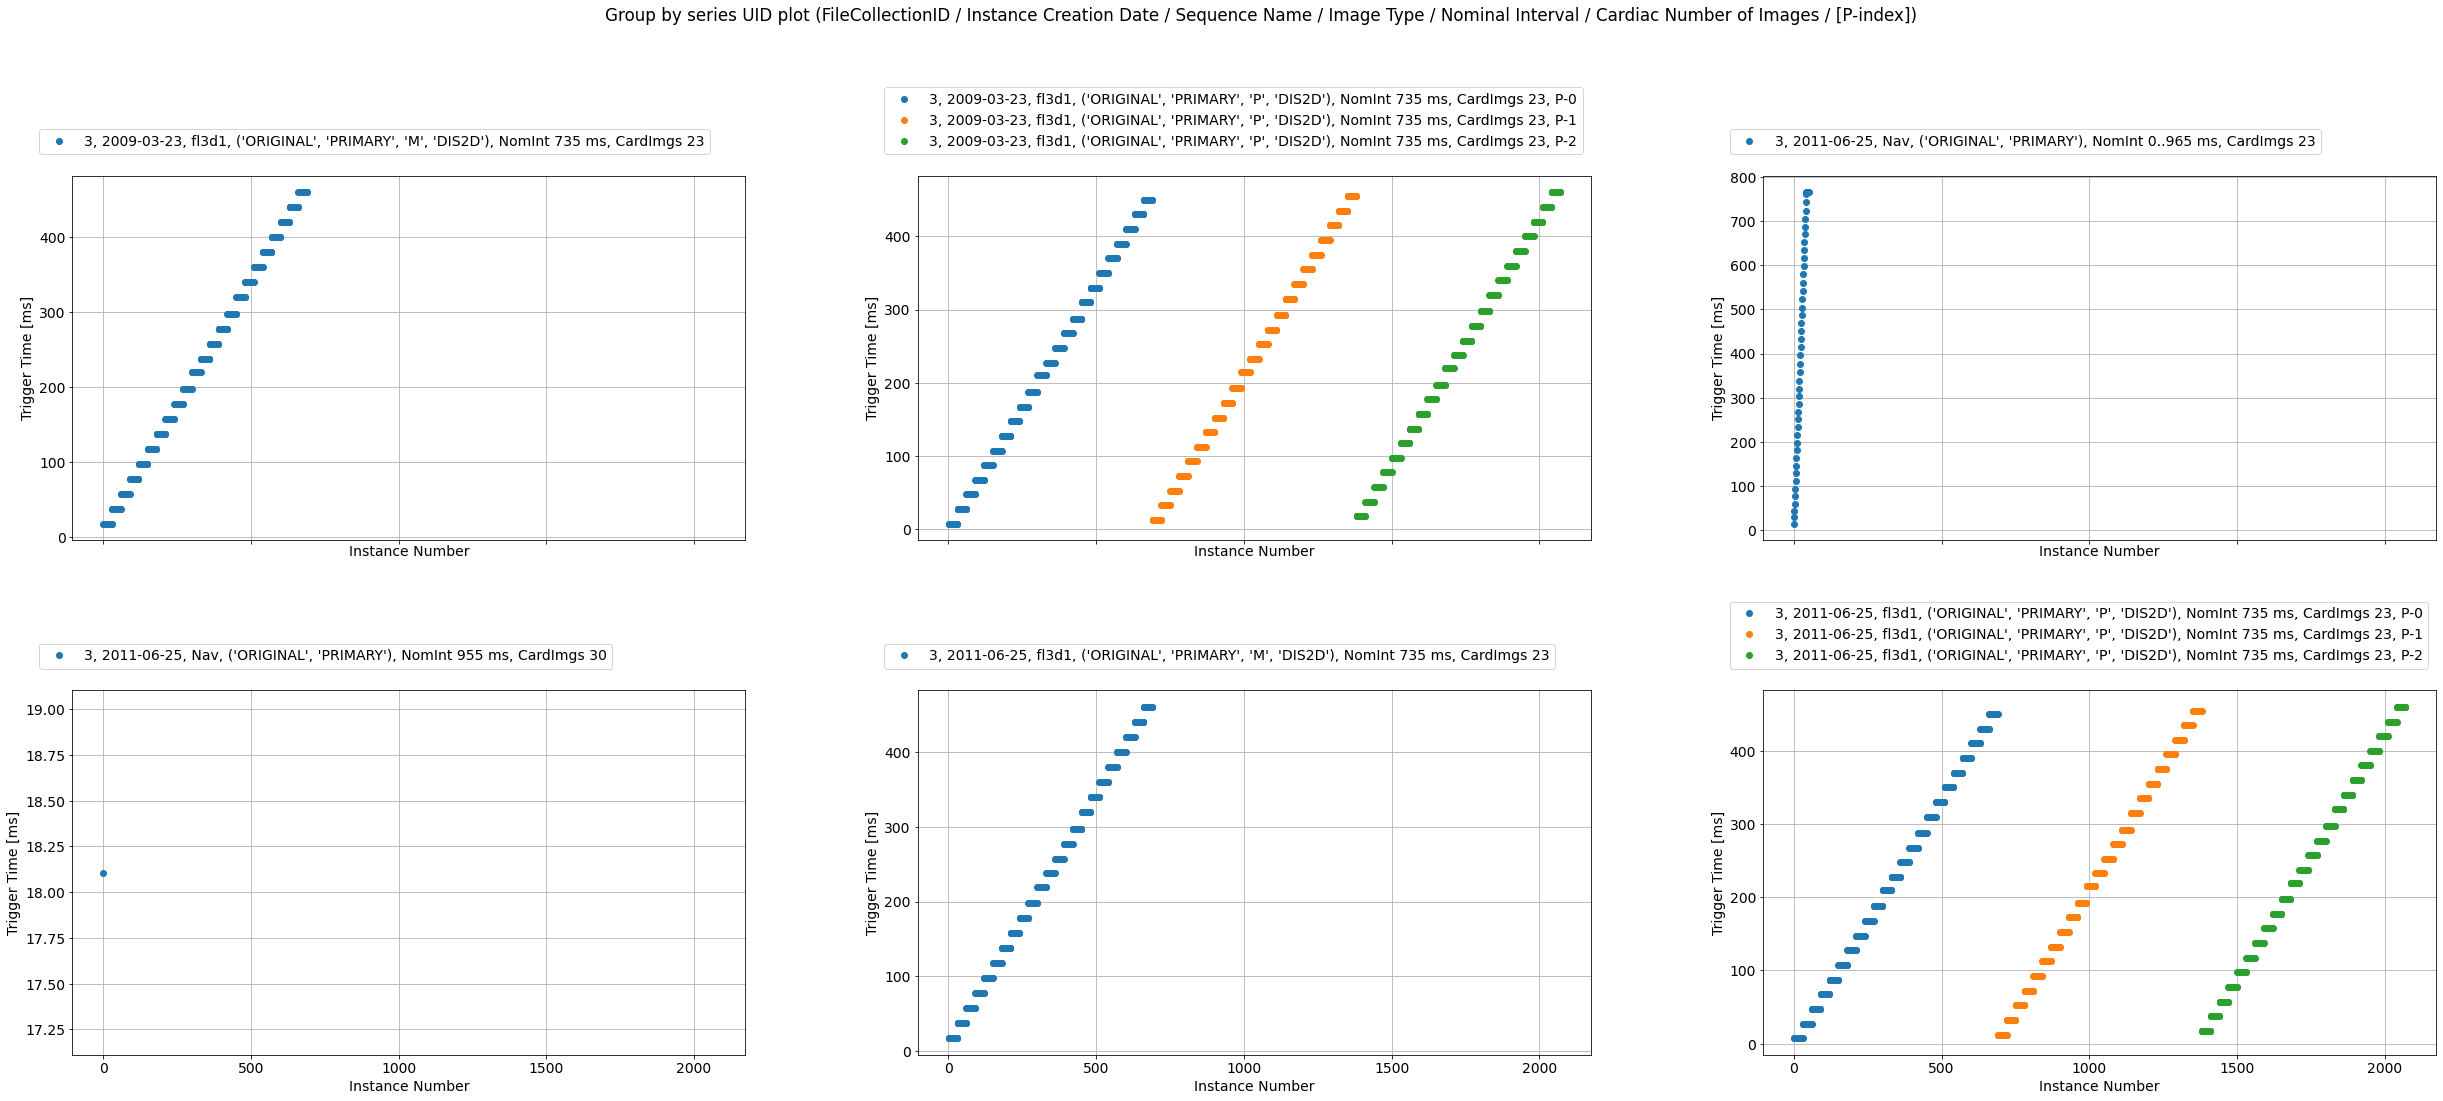

In [42]:
group_x_series = lambda group: group['Instance Number'] #.apply(lambda x: float(x.original_string))
x_label = 'Instance Number'
group_y_series = lambda group:  group['Trigger Time'] #.apply(lambda x: float(x.original_string))
y_label = 'Trigger Time [ms]'
#make_group_by_plot(df_renamed, group_x_series, x_label, group_y_series, y_label)
make_group_by_plot(df_grouped, group_x_series, x_label, group_y_series, y_label)


These plots clearly suggest that the P-series contain 3 sub-series that are sorted according to instance number (the visible plateau is due to multiple slices per fixed time being recorded one after another). 

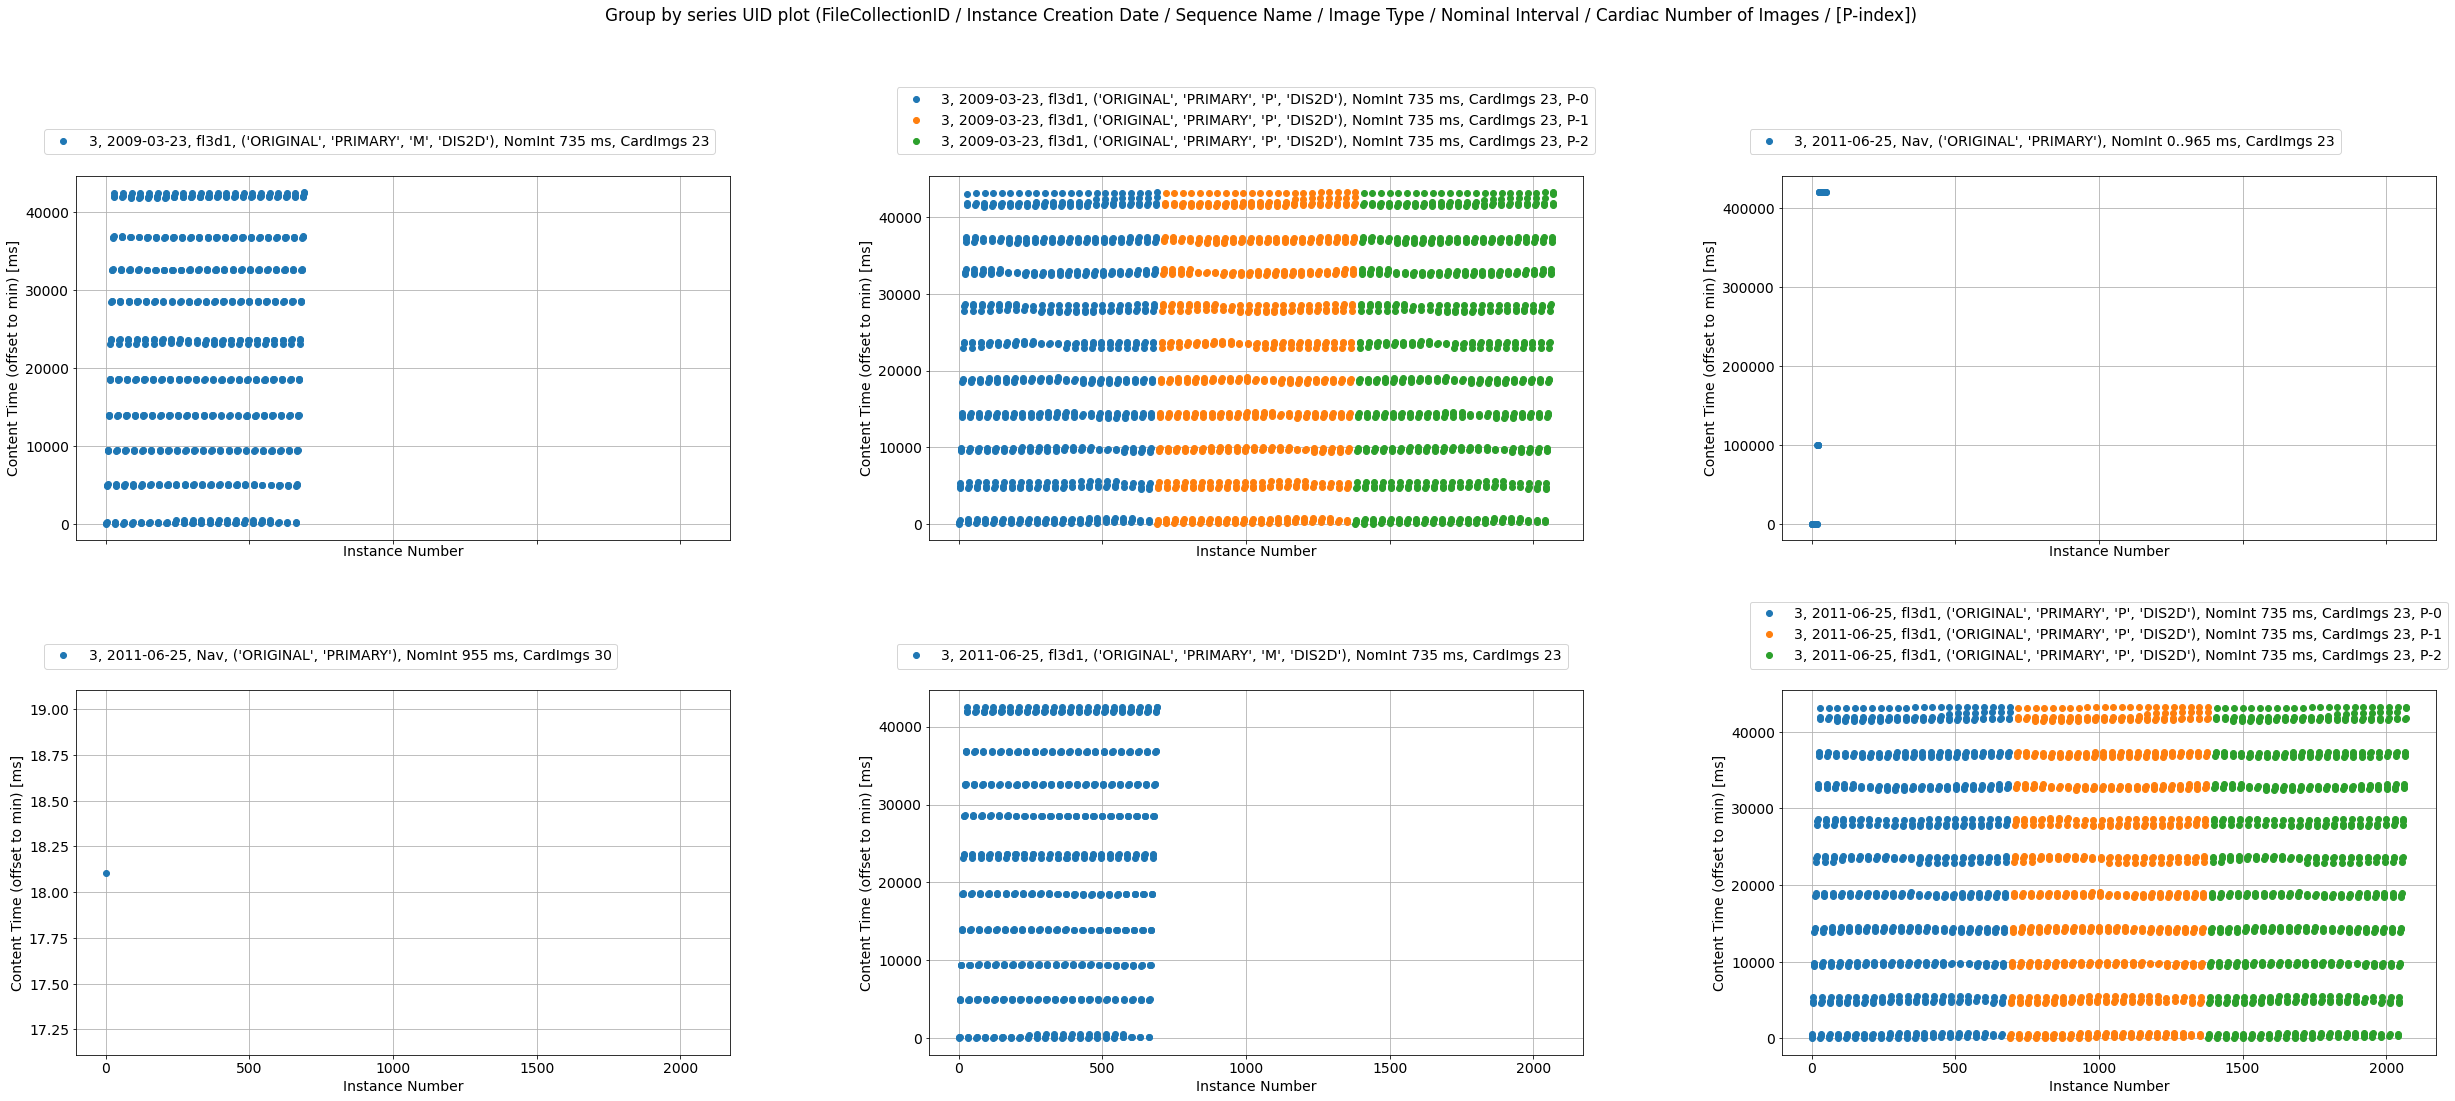

In [43]:
group_x_series = lambda group: group['Instance Number'] #.apply(lambda x: float(x.original_string))
x_label = 'Instance Number'
#group_y_series = lambda group:  (group['Content Datetime']-group['Content Datetime'].min()).apply(lambda x: x.total_seconds()*1e3)+group['Trigger Time'].apply(lambda x: float(x.original_string)).min()
group_y_series = lambda group: content_datetime_offset(group).apply(lambda x: x.total_seconds()*1e3)+group['Trigger Time'].min()
y_label = 'Content Time (offset to min) [ms]'
#make_group_by_plot(pd.concat([df_renamed, content_datetime], axis=1), group_x_series, x_label, group_y_series, y_label)
make_group_by_plot(df_grouped, group_x_series, x_label, group_y_series, y_label)


No correlation between content time and instance number.

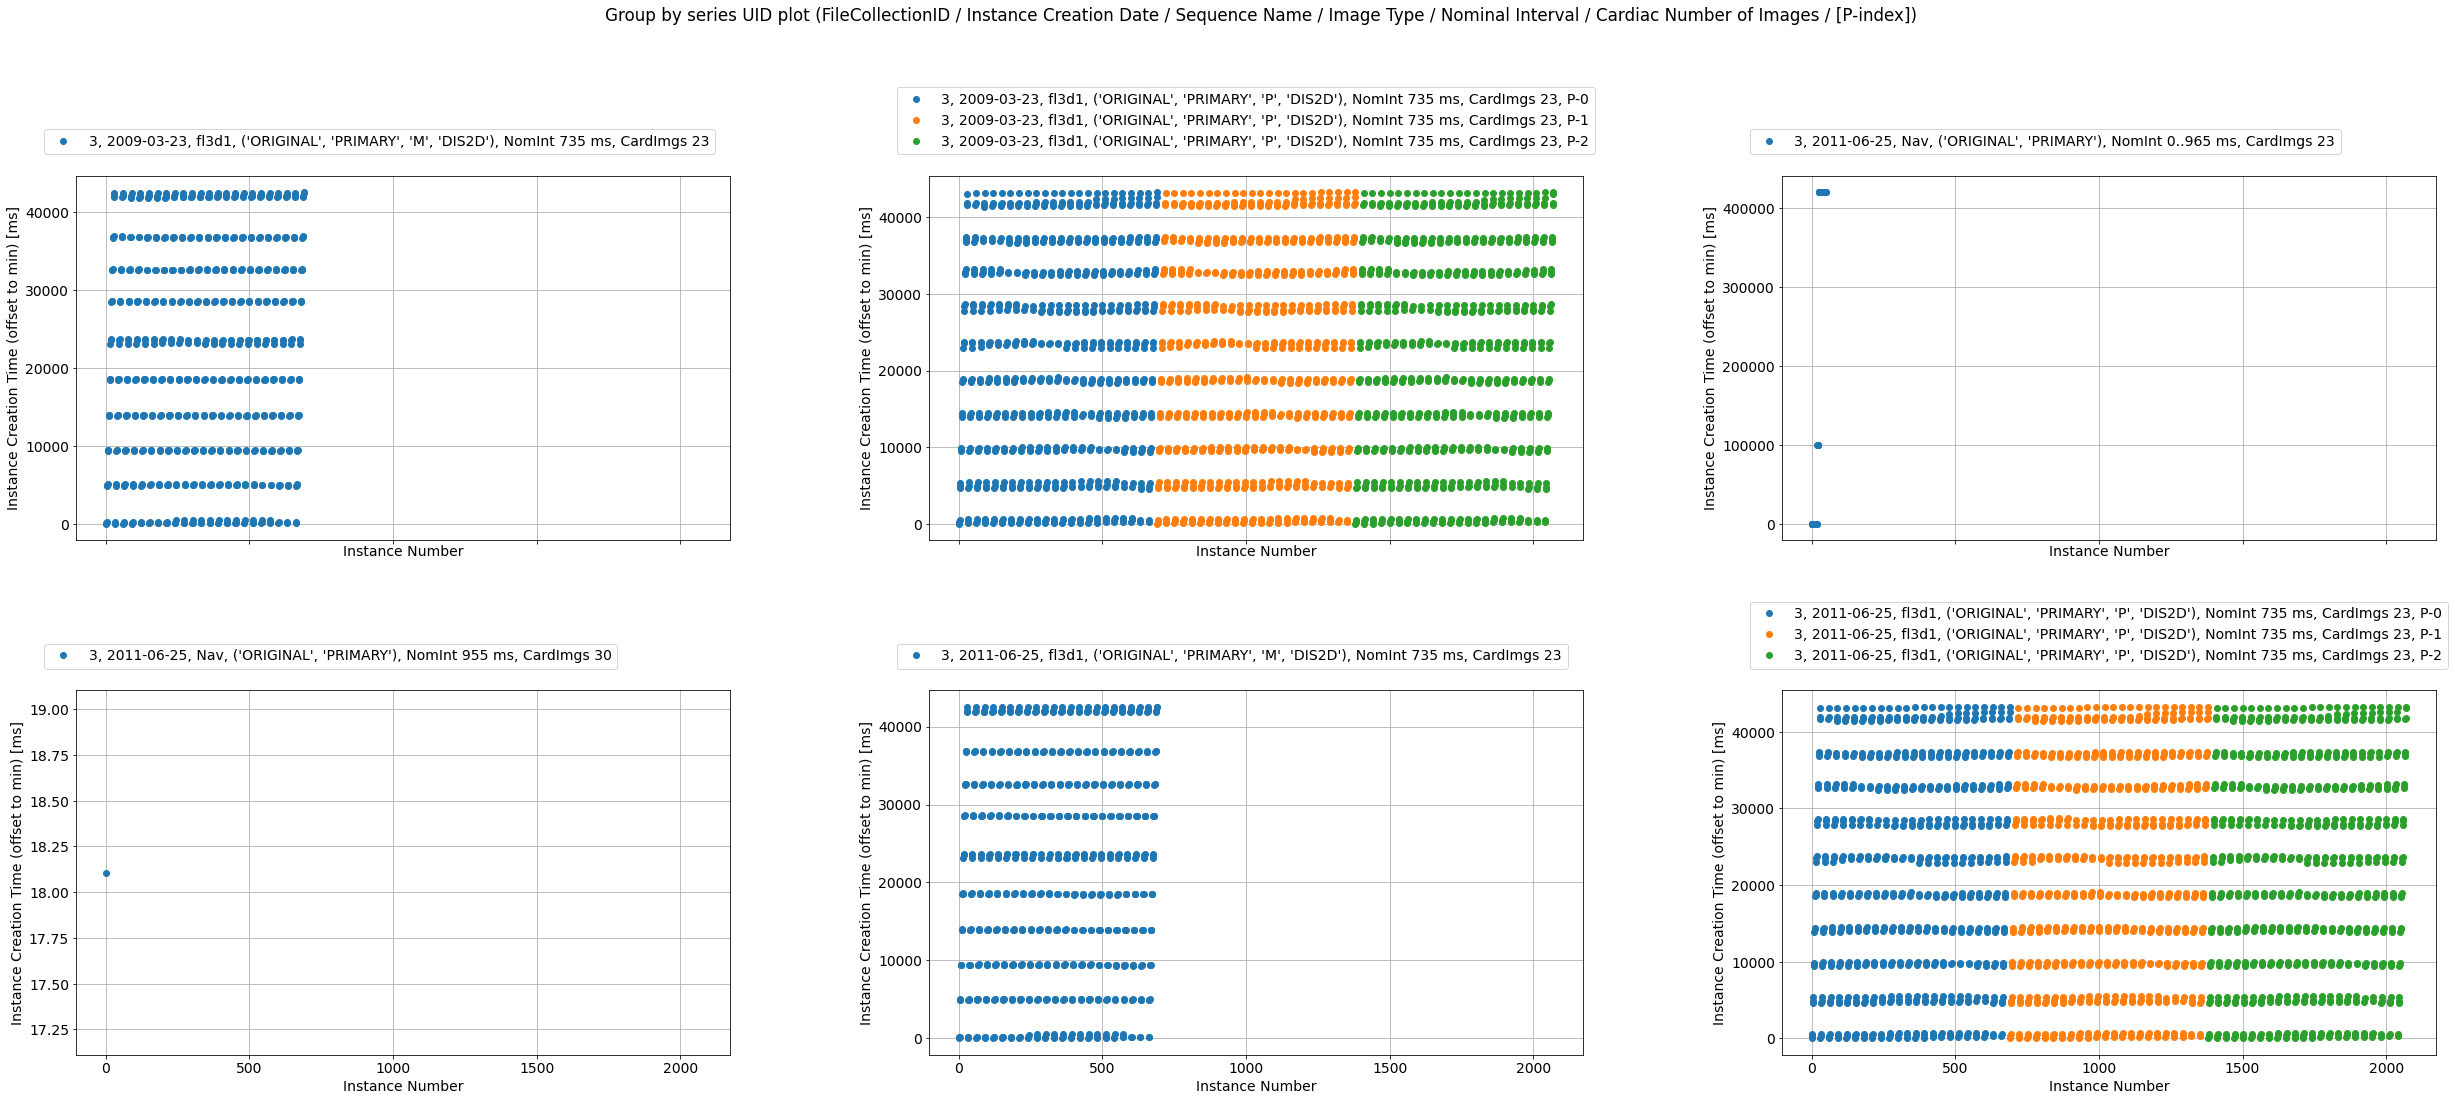

In [44]:
def instance_creation_datetime(df):
    return df.apply(
        lambda x: datetime.datetime(x['Series Date'].year, 
                                    x['Series Date'].month, 
                                    x['Series Date'].day, 
                                    x['Instance Creation Time'].hour, 
                                    x['Instance Creation Time'].minute,
                                    x['Instance Creation Time'].second, 
                                    x['Instance Creation Time'].microsecond, 
                                    x['Instance Creation Time'].tzinfo ), axis=1)

def instance_creation_datetime_offset(df):
    content_datetime_series = content_datetime(df)
    return content_datetime_series - content_datetime_series.min()


# instance_creation_datetime = pd.DataFrame({'Instance Creation Datetime': df_renamed.apply(
#     lambda x: datetime.datetime(x['Series Date'].value.year, 
#                                              x['Series Date'].value.month, 
#                                              x['Series Date'].value.day, 
#                                              x['Instance Creation Time'].value.hour, 
#                                              x['Instance Creation Time'].value.minute,
#                                              x['Instance Creation Time'].value.second, 
#                                              x['Instance Creation Time'].value.microsecond, 
#                                              x['Instance Creation Time'].value.tzinfo ), axis=1 )}).applymap(lambda x: SimpleNamespace(value=x))
# instance_creation_datetime

group_x_series = lambda group: group['Instance Number'] #.apply(lambda x: float(x.original_string))
x_label = 'Instance Number'
# group_y_series = lambda group:  (group['Instance Creation Datetime']-group['Instance Creation Datetime'].min()).apply(lambda x: x.total_seconds()*1e3)+group['Trigger Time'].apply(lambda x: float(x.original_string)).min()
group_y_series = lambda group: instance_creation_datetime_offset(group).apply(lambda x: x.total_seconds()*1e3)+group['Trigger Time'].min()
y_label = 'Instance Creation Time (offset to min) [ms]'
#make_group_by_plot(pd.concat([df_renamed, instance_creation_datetime], axis=1), group_x_series, x_label, group_y_series, y_label)
make_group_by_plot(df_grouped, group_x_series, x_label, group_y_series, y_label)


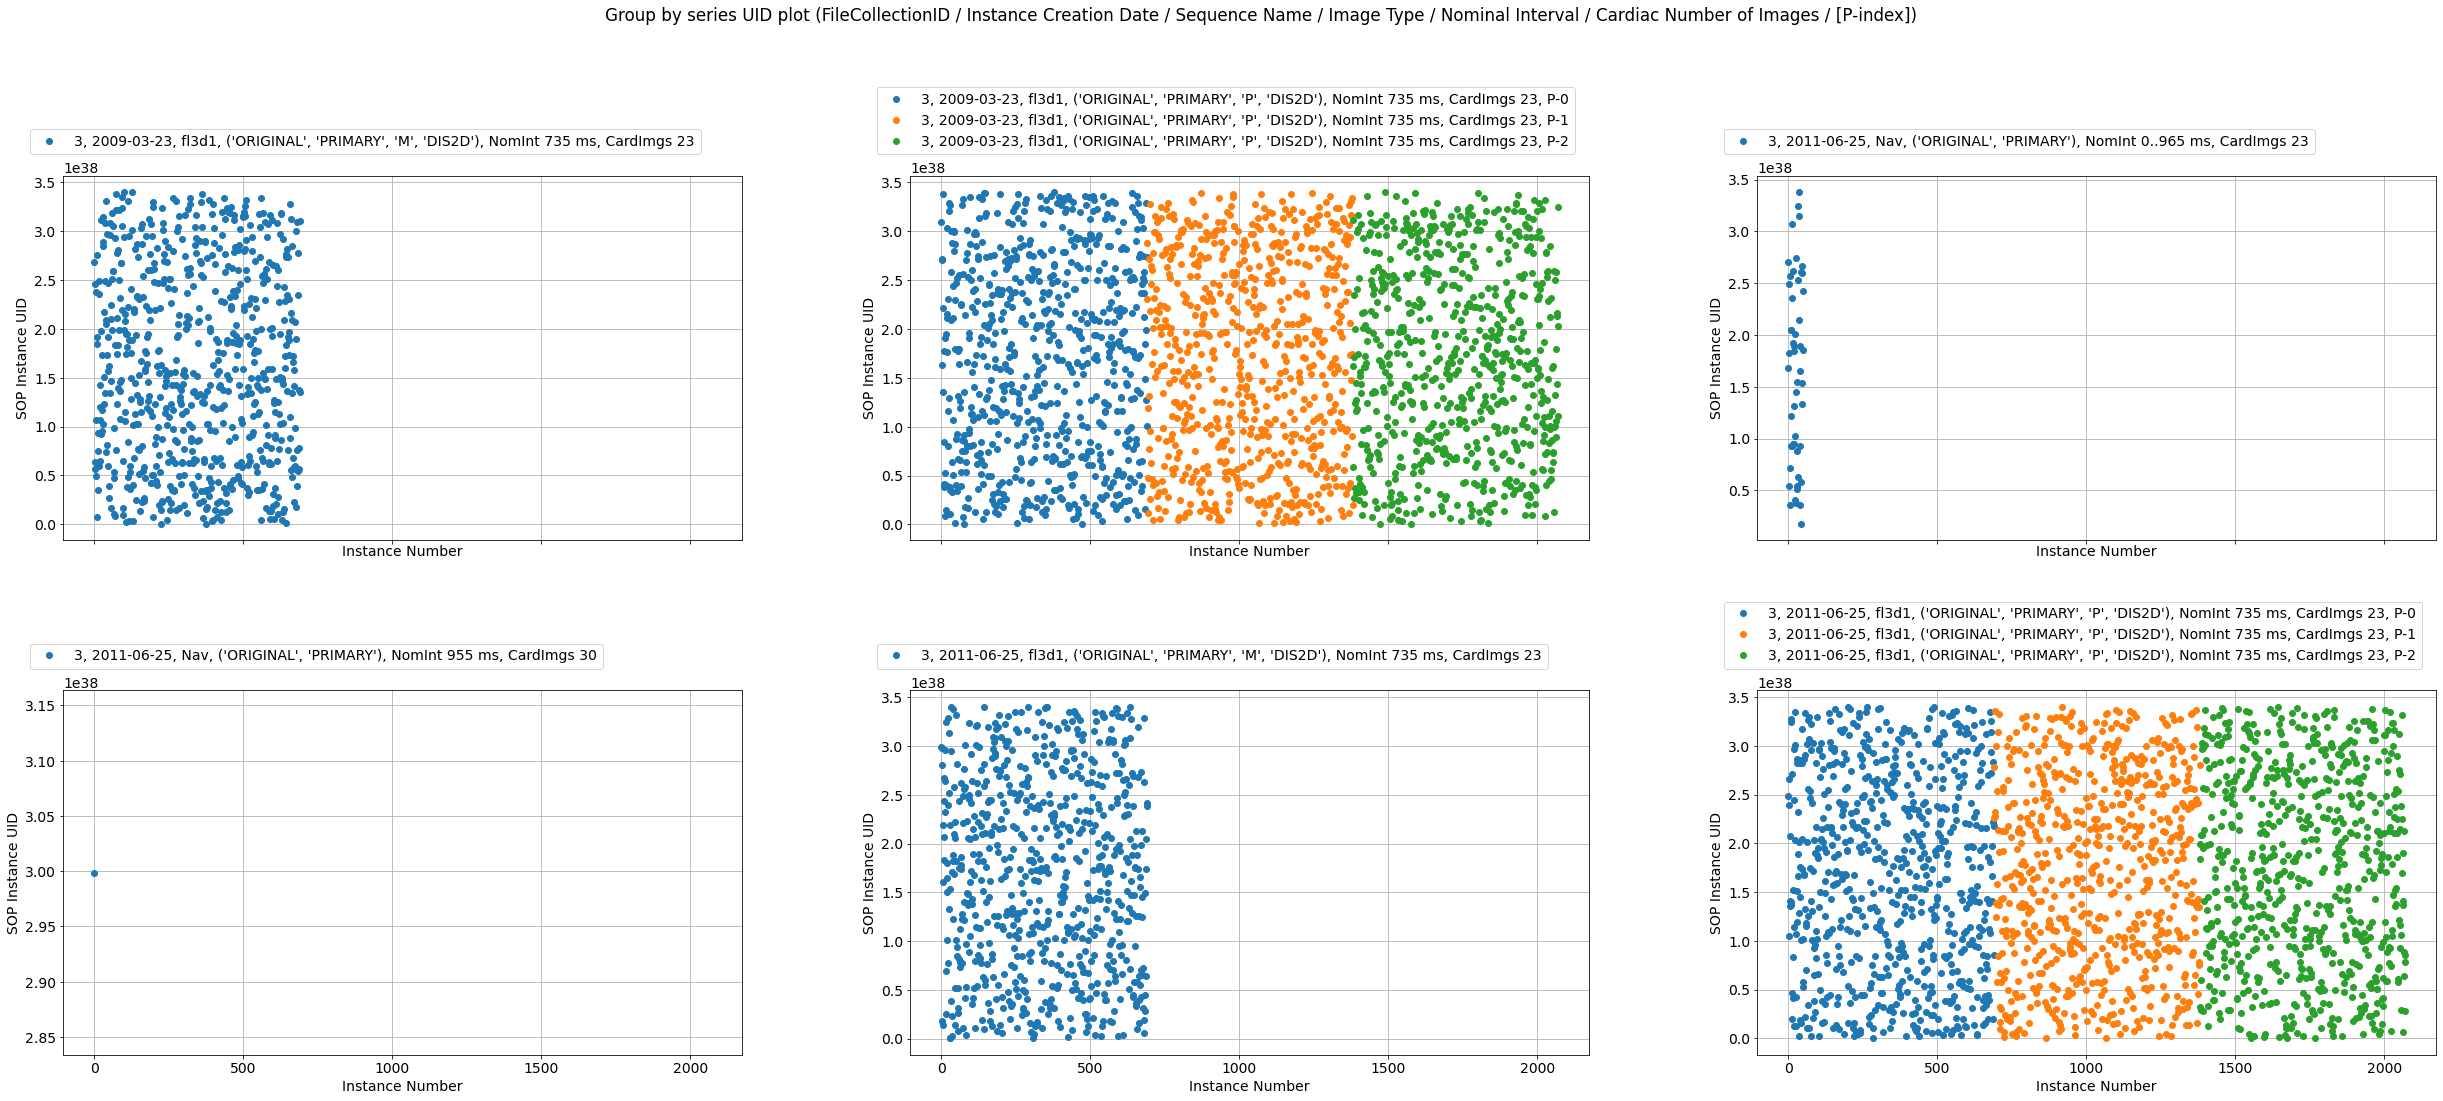

In [45]:
group_x_series = lambda group: group['Instance Number'] #.apply(lambda x: float(x.original_string))
x_label = 'Instance Number'
group_y_series = lambda group:  group['SOP Instance UID'].apply(lambda x: int(x.split('.')[-1])) #.apply(lambda x: int(x.uid.split('.')[-1]))
y_label = 'SOP Instance UID'
# make_group_by_plot(df_renamed, group_x_series, x_label, group_y_series, y_label)
make_group_by_plot(df_grouped, group_x_series, x_label, group_y_series, y_label)


For the SOP Instance UID interpreted as an integer there seems to be no correlation with Instance Number.

In [46]:
df_renamed_hashified['Slice Location'].iloc[0]

24.985648100769

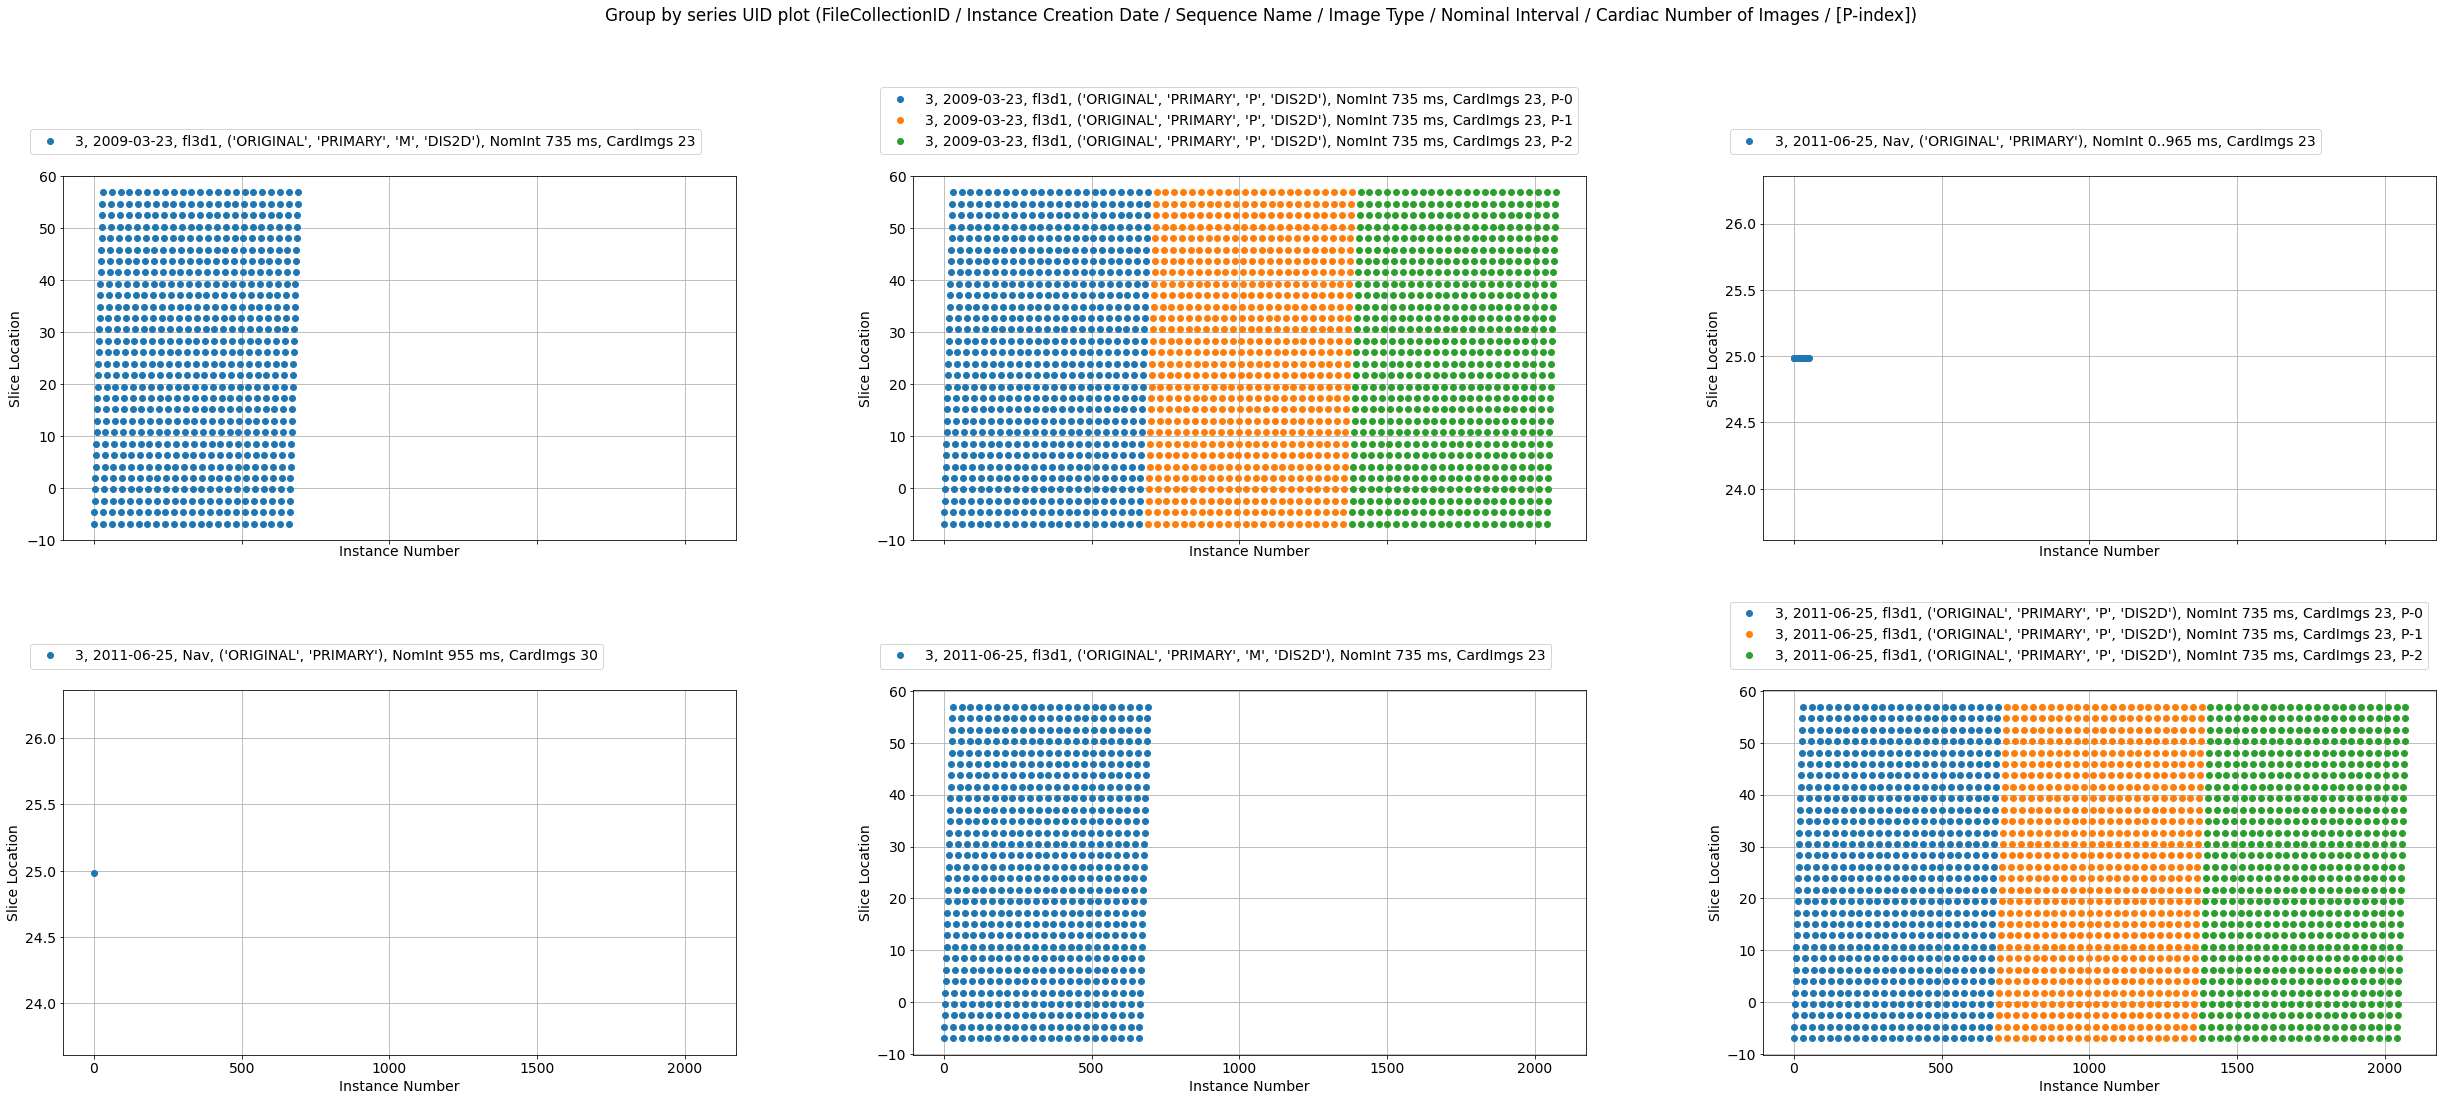

In [47]:
group_x_series = lambda group: group['Instance Number'] #.apply(lambda x: float(x.original_string))
x_label = 'Instance Number'
group_y_series = lambda group: group['Slice Location'] #.apply(lambda x: float(x.original_string))
y_label = 'Slice Location'
# make_group_by_plot(df_renamed, group_x_series, x_label, group_y_series, y_label)
make_group_by_plot(df_grouped, group_x_series, x_label, group_y_series, y_label)


In [48]:
# ds_float_multivalue_to_array = lambda x: np.array([float(c.original_string) for c in x.list])
# ds_float_multivalue_to_array(df_renamed_hashified.sort_values('Instance Number')['Image Position (Patient)'][0])

a= pd.DataFrame({'A': np.random.random(10)})
a['A'].idxmin()


6

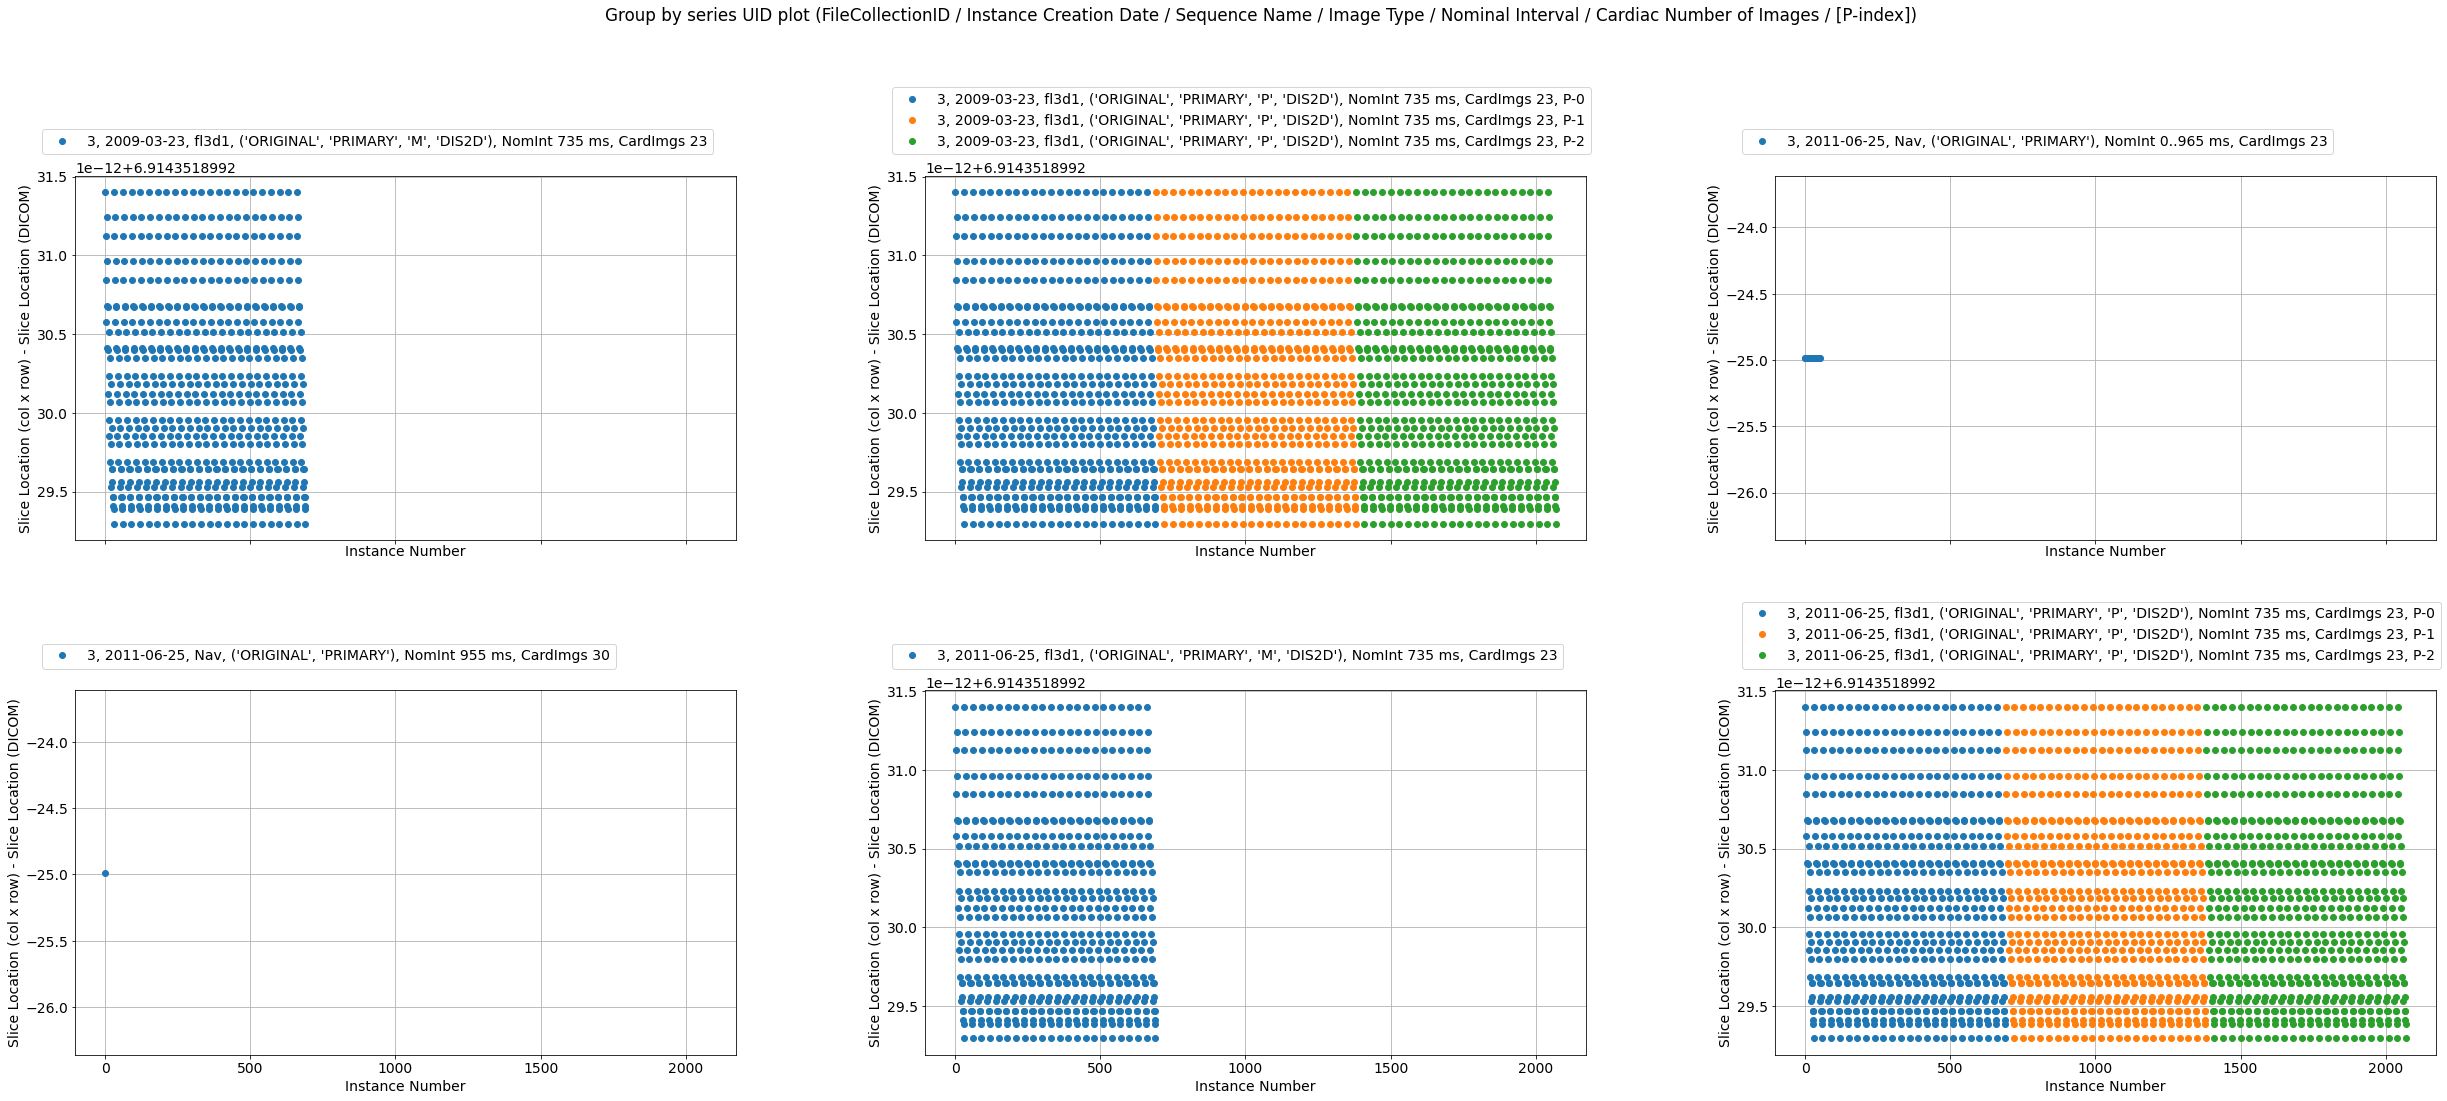

In [49]:
group_x_series = lambda group: group['Instance Number'] #.apply(lambda x: float(x.original_string))
x_label = 'Instance Number'

def slice_location_image_coord_sys(group):
#     ds_float_multivalue_to_array = lambda x: np.array([float(c.original_string) for c in x.list])

#     seq_origin = ds_float_multivalue_to_array(group.loc[group['Instance Number'].apply(lambda x: int(x.original_string)).idxmin(),'Image Position (Patient)'])    
    seq_origin = np.array(group.loc[group['Instance Number'].idxmin(),'Image Position (Patient)'])    
    orientation = group['Image Orientation (Patient)'].unique()
    assert len(orientation) == 1
#     row_unit = ds_float_multivalue_to_array(orientation[0])[:3]
#     col_unit = ds_float_multivalue_to_array(orientation[0])[3:]
    row_unit = np.array(orientation[0][:3])
    col_unit = np.array(orientation[0][3:])
    ort_unit = np.cross(col_unit, row_unit)

#     return group['Image Position (Patient)'].apply(lambda x: np.dot(ort_unit, ds_float_multivalue_to_array(x)-seq_origin) )
    return group['Image Position (Patient)'].apply(lambda x: np.dot(ort_unit, np.array(x)-seq_origin) )

def slice_location_diff(group):
    return slice_location_image_coord_sys(group) - group['Slice Location'].apply(lambda x: np.array(x))

group_y_series = slice_location_diff
y_label = 'Slice Location (col x row) - Slice Location (DICOM)'

#make_group_by_plot(df_renamed, group_x_series, x_label, group_y_series, y_label)
make_group_by_plot(df_grouped, group_x_series, x_label, group_y_series, y_label)

The coordinate system of the DICOM images produces the same alignment (with "Slice Location" as z-axis) when taking the column direction as the primary and row-direction as the secondary axis (i.e. x runs along the columns, y along the rows).

In [50]:
# for i, (name, group) in enumerate(pd.concat([df_renamed, instance_creation_datetime], axis=1).\
#     applymap(lambda x: hashify_pydicom(x.value) if pd.notnull(x) else x).\
#     groupby(['FileCollectionID', 'Instance Creation Date', 'Patient ID', 'Study Instance UID', 'Series Instance UID', 'Image Type', 'Sequence Name'])): # group['Instance Creation Date'].iloc[0]

for i, (name, group) in enumerate(df_grouped):

#     ds_float_multivalue_to_array = lambda x: np.array([float(c.original_string) for c in x.list])
        
    orientation = group['Image Orientation (Patient)'].unique()
    assert len(orientation) == 1
#     row_unit = ds_float_multivalue_to_array(orientation[0])[:3]
#     col_unit = ds_float_multivalue_to_array(orientation[0])[3:]
    row_unit = np.array(orientation[0][:3])
    col_unit = np.array(orientation[0][3:])
    ort_unit = np.cross(col_unit, row_unit)
    
    
#     if 'P' not in group['Image Type'].iloc[0].list:
    if 'P' not in group['Image Type'].iloc[0]:
#         print(name[0],name[1].original_string,name[5].list)
        print(name[0],name[1],name[5])
#         positions = group.sort_values('Instance Number')['Image Position (Patient)'].apply(ds_float_multivalue_to_array)    
        positions = group.sort_values('Instance Number')['Image Position (Patient)'].apply(lambda x: np.array(x))    
        print("max(dot(ort_unit,patient_position_offset)) = ")
        pprint((positions.iloc[1:] - positions[:-1]).apply(lambda x: np.abs(np.dot(ort_unit,x))).max())

    else:
        for j in range(3):
#             print(name[0],name[1].original_string,name[5].list, j)
            print(name[0],name[1],name[5], j)
            
#             select_subgroup = group['Instance Number'].apply(lambda x: j*group.shape[0]//3 < int(x.original_string) and int(x.original_string) <= (j+1)*group.shape[0]//3)            
            select_subgroup = group['Instance Number'].apply(lambda x: j*group.shape[0]//3 < x and x <= (j+1)*group.shape[0]//3)            

#             positions = group[select_subgroup].sort_values('Instance Number')['Image Position (Patient)'].apply(ds_float_multivalue_to_array)    
            positions = group[select_subgroup].sort_values('Instance Number')['Image Position (Patient)'].apply(lambda x: np.array(x))    
            print("max(dot(ort_unit,patient_position_offset)) = ")
            pprint((positions.iloc[1:] - positions[:-1]).apply(lambda x: np.abs(np.dot(ort_unit,x))).max())


3 2009-03-23 1.2.40.0.13.1.213723252275640155219987317546234930973
max(dot(ort_unit,patient_position_offset)) = 
0.0
3 2009-03-23 1.2.40.0.13.1.25036309036536625224276724877695836772 0
max(dot(ort_unit,patient_position_offset)) = 
0.0
3 2009-03-23 1.2.40.0.13.1.25036309036536625224276724877695836772 1
max(dot(ort_unit,patient_position_offset)) = 
0.0
3 2009-03-23 1.2.40.0.13.1.25036309036536625224276724877695836772 2
max(dot(ort_unit,patient_position_offset)) = 
0.0
3 2011-06-25 1.2.40.0.13.1.198221003098392982073940324396728676476
max(dot(ort_unit,patient_position_offset)) = 
0.0
3 2011-06-25 1.2.40.0.13.1.77035272634631905841303139920827311711
max(dot(ort_unit,patient_position_offset)) = 
nan
3 2011-06-25 1.2.40.0.13.1.66497147513520930083694369083190917481
max(dot(ort_unit,patient_position_offset)) = 
0.0
3 2011-06-25 1.2.40.0.13.1.79095444577104422254032466533737114681 0
max(dot(ort_unit,patient_position_offset)) = 
0.0
3 2011-06-25 1.2.40.0.13.1.79095444577104422254032466533737114

Image planes are orthogonal to Image Position (Patient) offset vector (note that the calculation wraps around time slice edges, i.e. it computes offsets between last and first Image Position (Patient), which, however, does not affect the conclusion).

In [51]:
#TODO:
# - Check that Cardiac number of images coincides with number of times (trigger/acquisition)
# - number of slice locations coincides with number of image position patients
# - and that both together with Rows and Columns explain the number of instances
# - statistics over unique values per series and conversion to HPC-PREDICT-IO/create MRI writer 

# Conversion to HDF5

In [25]:
df_grouped_unique[['FilePath']]

FilePath
FileCollectionID Instance Creation Date Patient ID    Study Instance UID                                 Sequence Name Series Instance UID                                Image Type                                                              
3                2009-03-23             ANONYM-REVX4  1.2.40.0.13.1.237828120959059386345548749032058... fl3d1         1.2.40.0.13.1.213723252275640155219987317546234... (ORIGINAL, PRIMARY) 0  [/home/lukasd/src/hpc-predict/data/v0/input_da...
                                                                                                                       1.2.40.0.13.1.250363090365366252242767248776958... (ORIGINAL, PRIMARY) 0  [/home/lukasd/src/hpc-predict/data/v0/input_da...
                 2011-06-25             ANONYM-KBPD3B 1.2.40.0.13.1.336917043524843706258805057826430... Nav           1.2.40.0.13.1.198221003098392982073940324396728... (ORIGINAL, PRIMARY) 0  [/home/lukasd/src/hpc-predict/data/v0/input_da...
                                                                                                                       1.2.40.0.13.1.770352726346319058413031399208273... (ORIGINAL, PRIMARY) 0  [/home/lukasd/src/hpc-predict/data/v0/input_da...
                                                                                                         fl3d1         1.2.40.0.13.1.664971475135209300836943690831909... (ORIGINAL, PRIMARY) 0  [/home/lukasd/src/hpc-predict/data/v0/input_da...
                                                                                                                       1.2.40.0.13.1.790954445771044222540324665337371... (ORIGINAL, PRIMARY) 0  [/home/lukasd/src/hpc-predict/data/v0/input_da...

In [26]:
print("Found sequence names {} (only processing fl3d1).".format(df_renamed_hashified['Sequence Name'].unique()))

group_by_series_keys = ['FileCollectionID', 'Instance Creation Date', 'Patient ID', 'Study Instance UID', 'Sequence Name'] #, 'Series Instance UID', 'Image Type']
df_flash_grouped = df_renamed_hashified[df_renamed_hashified['Sequence Name'] == 'fl3d1'].groupby(group_by_series_keys)

Found sequence names ['Nav' 'fl3d1'] (only processing fl3d1).


In [28]:
flow_mris = []

def extract_unique_value(group, col):
    value = group[col].unique()
    assert len(value) == 1; 
    return value[0]

for (name, group) in df_flash_grouped:

    magnitude = None
    phase = []
    
    for (series_name, series_group) in group.groupby(['Series Instance UID', 'Image Type']):
        if 'M' in series_name[1]:
            magnitude = series_group.sort_values('Instance Number')
        elif 'P' in series_name[1]:
            phase_group = series_group.sort_values('Instance Number')
            phase = [ phase_group[ phase_group['Instance Number'].apply(
                lambda x: j*phase_group.shape[0]//3 < x and x <= (j+1)*phase_group.shape[0]//3) ] 
                     for j in range(3) ]           

    num_rows = extract_unique_value(group, 'Rows')
    num_cols = extract_unique_value(group, 'Columns')
    num_slice_locations = len(group['Slice Location'].unique()) # FIXME: sanity check!
    cardiac_number_of_images = extract_unique_value(group, 'Cardiac Number of Images')
    
    assert magnitude.shape[0] == num_slice_locations*cardiac_number_of_images
    for j in range(3):
        assert phase[j].shape[0] == num_slice_locations*cardiac_number_of_images

    orientation = extract_unique_value(group, 'Image Orientation (Patient)')
    row_unit = np.array(orientation[:3])
    col_unit = np.array(orientation[3:])
    ort_unit = np.cross(col_unit, row_unit)
    assert (np.linalg.norm(ort_unit) - 1.) < 1e-12

    magnitude_positions = magnitude['Image Position (Patient)'].apply(lambda x: np.array(x))    
    magnitude_position_origin = np.array(magnitude.loc[magnitude['Instance Number'].idxmin(),'Image Position (Patient)'])    
    magnitude_slice_position_shift = magnitude_positions.apply(lambda x: np.dot(ort_unit,x - magnitude_position_origin)) - magnitude['Slice Location']    
    assert (magnitude_slice_position_shift - magnitude_slice_position_shift.mean()).abs().max() < 1e-11
    
    slice_locations = magnitude['Slice Location'][:num_slice_locations].values # FIXME: sanity check!
    assert len(np.unique(slice_locations)) == num_slice_locations
#     magnitude_slice_locations = magnitude['Slice Location'][:num_slice_locations].values    
    magnitude_trigger_times = magnitude['Trigger Time'][::num_slice_locations].values
    assert len(np.unique(magnitude_trigger_times)) == cardiac_number_of_images
    magnitude_values = np.ndarray(shape=(num_rows, num_cols, num_slice_locations, cardiac_number_of_images))
    # TODO: Check correctness of pixel value reading
    for t,_ in enumerate(magnitude_trigger_times):
        for z,_ in enumerate(slice_locations): # magnitude_slice_locations
            img_row = magnitude[magnitude['Instance Number'] == t*num_slice_locations + z + 1]; assert len(img_row) == 1; img_row = img_row.iloc[0]
            dcm_img = pydicom.dcmread(img_row['FilePath'])
            magnitude_values[:,:,z,t] = dcm_img.pixel_array # no rescale properties
   

    phase_positions = []
    phase_slice_locations = []
    phase_trigger_times = []
    phase_values = np.ndarray(shape=(num_rows, num_cols, num_slice_locations, cardiac_number_of_images, 3))
    for j in range(3):
        # If this does not work can validate the phase z-coordinates here as well
        assert (slice_locations == phase[j]['Slice Location'][:num_slice_locations].values).all()

#         phase_slice_locations.append( phase[j]['Slice Location'][:num_slice_locations].values )    
        phase_trigger_times.append( phase[j]['Trigger Time'][::num_slice_locations].values )
        print("Trigger time offsets of phase[{}] relative to magnitude in {} ms".format(j, np.unique(phase_trigger_times[j]-magnitude_trigger_times)), flush=True)
        for t,_ in enumerate(phase_trigger_times[j]):
            for z,_ in enumerate(slice_locations): # phase_slice_locations[j]
                img_row = phase[j][phase[j]['Instance Number'] == j*cardiac_number_of_images*num_slice_locations + t*num_slice_locations + z + 1]; assert len(img_row) == 1; img_row = img_row.iloc[0]
                dcm_img = pydicom.dcmread(img_row['FilePath'])
                phase_values[:,:,z,t,j] = dcm_img.RescaleSlope*dcm_img.pixel_array+dcm_img.RescaleIntercept

    
    #check for uniqueness!
    pixel_spacing = extract_unique_value(group, 'Pixel Spacing')
    geometry = [pixel_spacing[0]*(np.arange(0,num_rows)+0.5),
                pixel_spacing[1]*(np.arange(0,num_cols)+0.5),
                slice_locations]

    #check for uniqueness!
    #group['Nominal Interval'].unique()  #.apply(lambda x: agg_unique(x))
    heart_cycle_period = group['Nominal Interval'].mean()
    
    print("Writing {} to HDF5...".format(name))
    flow_mris.append({
        "cardiac_number_of_images": cardiac_number_of_images,
        "num_slice_locations": num_slice_locations,
        "heart_cycle_period": heart_cycle_period,
        "geometry": geometry,
        "magnitude_trigger_times": magnitude_trigger_times,
        "magnitude_values": magnitude_values, #"phase_slice_locations": phase_slice_locations,
        "phase_trigger_times": phase_trigger_times,
        "phase_values": phase_values,        
    })
## df_grouped_unique = df_grouped.apply(lambda x: agg_unique(x))   # 
    
    
    

Trigger time offsets phase[0] - magnitude in [-10.] ms
Trigger time offsets phase[1] - magnitude in [-5.] ms
Trigger time offsets phase[2] - magnitude in [0.] ms
Writing (3, datetime.date(2009, 3, 23), 'ANONYM-REVX4', '1.2.40.0.13.1.237828120959059386345548749032058253715', 'fl3d1') to HDF5...
Trigger time offsets phase[0] - magnitude in [-10.] ms
Trigger time offsets phase[1] - magnitude in [-5.] ms
Trigger time offsets phase[2] - magnitude in [0.] ms
Writing (3, datetime.date(2011, 6, 25), 'ANONYM-KBPD3B', '1.2.40.0.13.1.336917043524843706258805057826430066425', 'fl3d1') to HDF5...


In [35]:
import sys
if not '/home/lukasd/src/review/hpc-predict-io/python' in sys.path:
    sys.path.append('/home/lukasd/src/review/hpc-predict-io/python')

In [31]:
from mr_io import FlowMRI

hpc_predict_mri = FlowMRI(geometry=geometry, 
                          time=magnitude_trigger_times, # FIXME: phase times!
                          time_heart_cycle_period=heart_cycle_period, 
                          intensity=magnitude_values, 
                          velocity_mean=phase_values, 
                          velocity_cov=np.zeros(shape=phase_values.shape+(3,)))
# FlowMRI?

In [32]:
filename = "{}-{}-{}.h5".format(name[0], name[1], name[3])
hpc_predict_mri.write_hdf5(filename)

read_result = FlowMRI.read_hdf5(filename)

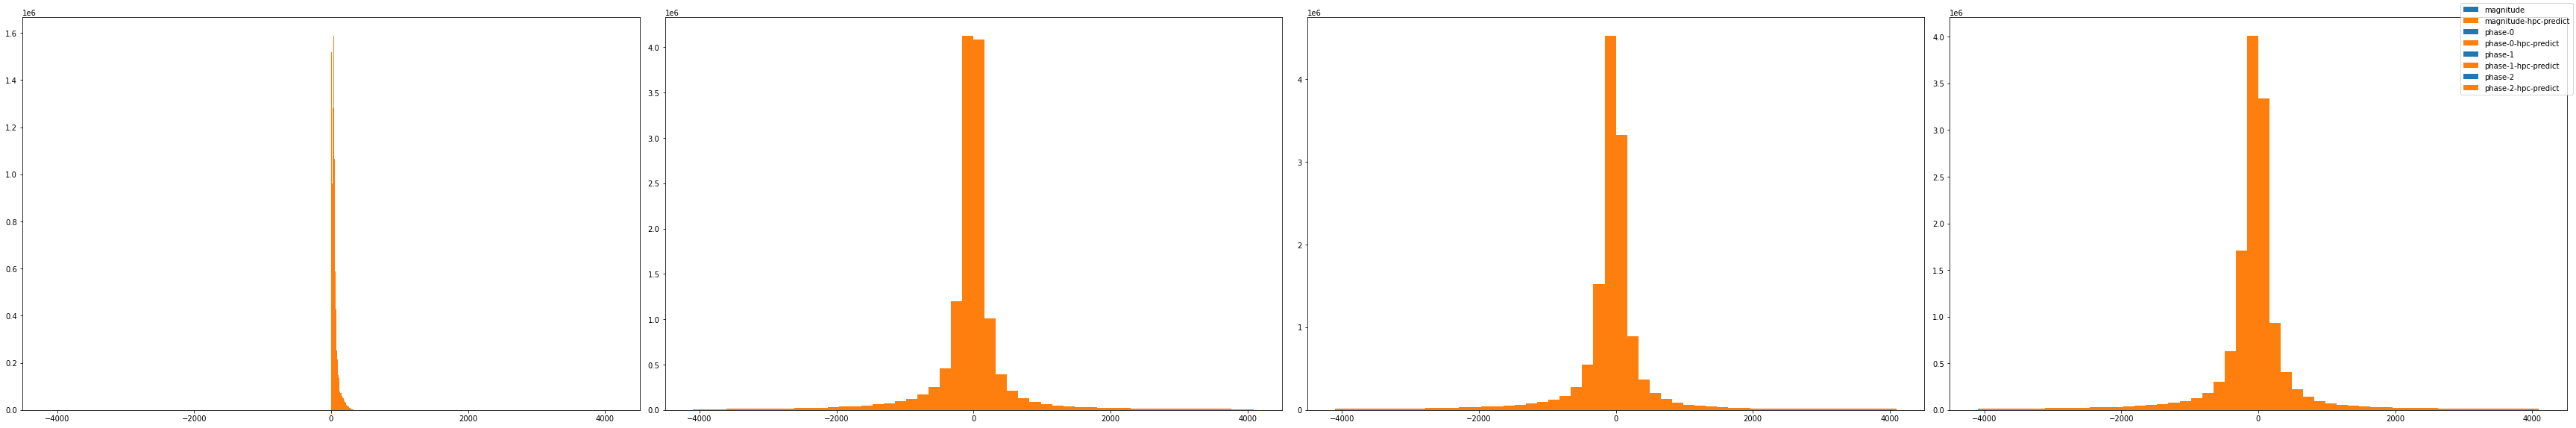

In [34]:
import matplotlib.pyplot as plt

figure, ax = plt.subplots(ncols=4, sharex=True, figsize=(12*4,8*1))
ax[0].hist(flow_mris[0]['magnitude_values'].flatten(), bins=50, label='magnitude')
ax[0].hist(hpc_predict_mri.intensity.flatten(), bins=50, label='magnitude-hpc-predict') # Todo: make this semitransparent
for j in range(3):
    ax[j+1].hist(flow_mris[0]['phase_values'][:,:,:,:,j].flatten(), bins=50, label='phase-{}'.format(j))
    ax[j+1].hist(hpc_predict_mri.velocity_mean[:,:,:,:,j].flatten(), bins=50, label='phase-{}-hpc-predict'.format(j))
figure.legend()
figure.tight_layout()

Looks good on samples. Phase/velocity units remain to be determined. According to analysis below, all sequences are either fl3d1 or fl3d1_2 in the dataset. The code can be moved to a script that does the conversion.

# Dataset-wide analysis of per-series unique values

## Parse extracted unique DICOM header lists

In [60]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pydicom

import matplotlib.dates as mdates
import re

pkls = sorted(glob("/home/lukasd/src/hpc-predict/data/v0/input_data/preprocessed/mri/MRT Daten Bern DICOM Header Unique/*.pkl"), key=lambda x: int(os.path.basename(x).split('.')[0]) )
pkls

['/home/lukasd/src/hpc-predict/data/v0/input_data/preprocessed/mri/MRT Daten Bern DICOM Header Unique/3.pkl',
 '/home/lukasd/src/hpc-predict/data/v0/input_data/preprocessed/mri/MRT Daten Bern DICOM Header Unique/4.pkl',
 '/home/lukasd/src/hpc-predict/data/v0/input_data/preprocessed/mri/MRT Daten Bern DICOM Header Unique/5.pkl',
 '/home/lukasd/src/hpc-predict/data/v0/input_data/preprocessed/mri/MRT Daten Bern DICOM Header Unique/6.pkl',
 '/home/lukasd/src/hpc-predict/data/v0/input_data/preprocessed/mri/MRT Daten Bern DICOM Header Unique/7.pkl',
 '/home/lukasd/src/hpc-predict/data/v0/input_data/preprocessed/mri/MRT Daten Bern DICOM Header Unique/9.pkl',
 '/home/lukasd/src/hpc-predict/data/v0/input_data/preprocessed/mri/MRT Daten Bern DICOM Header Unique/10.pkl',
 '/home/lukasd/src/hpc-predict/data/v0/input_data/preprocessed/mri/MRT Daten Bern DICOM Header Unique/11.pkl',
 '/home/lukasd/src/hpc-predict/data/v0/input_data/preprocessed/mri/MRT Daten Bern DICOM Header Unique/12.pkl',
 '/home

In [61]:
pd.set_option('display.max_columns', None)

df_unique = []
df_skipped = []
for pkl in pkls:
    read_pkl = pd.read_pickle(pkl)
    labels, counts = np.unique(read_pkl.columns.values, return_counts=True)
    print("Dropping {} from {}".format(labels[counts > 1], os.path.basename(pkl)))
    read_pkl = read_pkl.drop(labels=labels[counts > 1], axis=1)

    read_pkl_deidentified = read_pkl['De-identification Method Code Sequence'].apply(lambda x: hasattr(x,'__len__') and len(x) == 1 and hasattr(x[0],'__len__') and len(x[0]) > 0)
    if (~read_pkl_deidentified).sum() > 0:
        print("WARNING: Found {} series in studies {} in {} without de-identification tags - skipping them!".format(read_pkl_deidentified.sum(), list(read_pkl[~read_pkl_deidentified]['Study Instance UID'].apply(lambda x: x[0]).unique()), os.path.basename(pkl)))
        df_skipped.append(read_pkl[~read_pkl_deidentified])
    read_pkl = read_pkl[read_pkl_deidentified]
    
    df_unique.append(read_pkl)

df_unique = pd.concat(df_unique, axis=0)
df_skipped = pd.concat(df_skipped, axis=0) 
df_unique

Dropping ['Private Creator'] from 3.pkl
Dropping ['Private Creator'] from 4.pkl
Dropping ['Private Creator'] from 5.pkl
Dropping ['Private Creator'] from 6.pkl
Dropping ['Private Creator'] from 7.pkl
Dropping ['Private Creator'] from 9.pkl
Dropping ['Private Creator'] from 10.pkl
Dropping ['Private Creator'] from 11.pkl
Dropping ['Private Creator'] from 12.pkl
Dropping ['Private Creator'] from 14.pkl
Dropping ['Private Creator'] from 15.pkl
Dropping ['Private Creator'] from 16.pkl
Dropping ['Private Creator'] from 17.pkl
Dropping ['Private Creator'] from 21.pkl
Dropping ['Private Creator'] from 22.pkl
Dropping ['Private Creator'] from 23.pkl
Dropping ['Private Creator'] from 24.pkl
Dropping ['Private Creator'] from 25.pkl
Dropping ['Private Creator'] from 26.pkl
Dropping ['Private Creator'] from 27.pkl
Dropping ['Private Creator'] from 28.pkl
Dropping ['Private Creator'] from 29.pkl
Dropping ['Private Creator'] from 30.pkl
Dropping ['Private Creator'] from 31.pkl
Dropping ['Private Cre

Specific Character Set  \
FileCollectionID Instance Creation Date Patient ID    Study Instance UID                                 Sequence Name Series Instance UID                                Image Type                                     
3                2009-03-23             ANONYM-REVX4  1.2.40.0.13.1.237828120959059386345548749032058... fl3d1         1.2.40.0.13.1.213723252275640155219987317546234... (ORIGINAL, PRIMARY) 0           [ISO_IR 100]   
                                                                                                                       1.2.40.0.13.1.250363090365366252242767248776958... (ORIGINAL, PRIMARY) 0           [ISO_IR 100]   
                 2011-06-25             ANONYM-KBPD3B 1.2.40.0.13.1.336917043524843706258805057826430... Nav           1.2.40.0.13.1.198221003098392982073940324396728... (ORIGINAL, PRIMARY) 0           [ISO_IR 100]   
                                                                                                                       1.2.40.0.13.1.770352726346319058413031399208273... (ORIGINAL, PRIMARY) 0           [ISO_IR 100]   
                                                                                                         fl3d1         1.2.40.0.13.1.664971475135209300836943690831909... (ORIGINAL, PRIMARY) 0           [ISO_IR 100]   
...                                                                                                                                                                                                                ...   
148              2013-06-11             ANONYM-JWJLSU 1.2.40.0.13.1.299106762787475685927449967090451... fl3d1         1.2.40.0.13.1.124363119240975454282317047061690... (ORIGINAL, PRIMARY) 0           [ISO_IR 100]   
                                                                                                                       1.2.40.0.13.1.224820703509406246127405111230565... (ORIGINAL, PRIMARY) 0           [ISO_IR 100]   
149              2011-02-26             ANONYM-ZERI78 1.2.40.0.13.1.302616599070271638287565912761840... Nav           1.2.40.0.13.1.299534719495101407983760977496677... (ORIGINAL, PRIMARY) 0           [ISO_IR 100]   
                                                                                                         fl3d1         1.2.40.0.13.1.167498948539274632630921342391629... (ORIGINAL, PRIMARY) 0           [ISO_IR 100]   
                                                                                                                       1.2.40.0.13.1.334802931737932781838327577019930... (ORIGINAL, PRIMARY) 0           [ISO_IR 100]   

                                                                                                                                                                                                                      Image Type  \
FileCollectionID Instance Creation Date Patient ID    Study Instance UID                                 Sequence Name Series Instance UID                                Image Type                                               
3                2009-03-23             ANONYM-REVX4  1.2.40.0.13.1.237828120959059386345548749032058... fl3d1         1.2.40.0.13.1.213723252275640155219987317546234... (ORIGINAL, PRIMARY) 0  [(ORIGINAL, PRIMARY, M, DIS2D)]   
                                                                                                                       1.2.40.0.13.1.250363090365366252242767248776958... (ORIGINAL, PRIMARY) 0  [(ORIGINAL, PRIMARY, P, DIS2D)]   
                 2011-06-25             ANONYM-KBPD3B 1.2.40.0.13.1.336917043524843706258805057826430... Nav           1.2.40.0.13.1.198221003098392982073940324396728... (ORIGINAL, PRIMARY) 0            [(ORIGINAL, PRIMARY)]   
                                                                                                                       1.2.40.0.13.1.770352726346319058413031399208273... (ORIGINAL, PRIMARY) 0            [(ORIGINAL, PR

### Validate anonymization with de-identification tags

In [52]:
print("Checking for any non-anonymized DICOM images")
df_skipped_folders = {collection: pd.read_pickle("/home/lukasd/src/hpc-predict/data/v0/input_data/preprocessed/mri/MRT Daten Bern DICOM Header/{}.pkl".format(collection)) for collection in df_skipped['FileCollectionID'].apply(lambda x: x[0]).unique()}
for collection, df_skipped_folder in df_skipped_folders.items():
    print("Evaluating FileCollectionID {} for missing de-identification tags".format(collection))

    df_skipped_folder_hashified = df_skipped_folder.rename(columns=df_skipped_folder.apply( lambda c: c.dropna().apply(lambda x: x.name).unique(), axis=0).iloc[0].to_dict())\
                                                   .applymap(lambda x: hashify_pydicom(x.value) if pd.notnull(x) else x)
    df_skipped_folder_anonymized = df_skipped_folder_hashified['De-identification Method Code Sequence'].apply(lambda x: hasattr(x,'__len__') and len(x) > 0)
    df_skipped_folder_unaffected = df_skipped_folder_hashified[df_skipped_folder_anonymized]
    df_skipped_folder_affected = df_skipped_folder_hashified[~df_skipped_folder_anonymized]

    print("Affected studies:   {} ".format(df_skipped_folder_affected['Study Instance UID'].unique()))
    print("      -> folders:   {} ".format(df_skipped_folder_affected['FilePath'].apply(lambda x: '/'.join(x.split('/')[-5:-2]) ).unique()))
    print("Unaffected studies: {} ".format(df_skipped_folder_unaffected['Study Instance UID'].unique()))
    print("      ->   folders: {} ".format(df_skipped_folder_unaffected['FilePath'].apply(lambda x: '/'.join(x.split('/')[-5:-2]) ).unique()))

Evaluating FileCollectionID 127
Affected studies:   ['1.2.276.0.38.1.1.1.3150.20140520105617.27084519'] 
         folders:   ['127/10005583/10005584'] 
Unaffected studies: ['1.2.40.0.13.1.323582226551910976210288980738898346116'] 
           folders: ['127/10005671/10005672'] 


## Overview of sequences

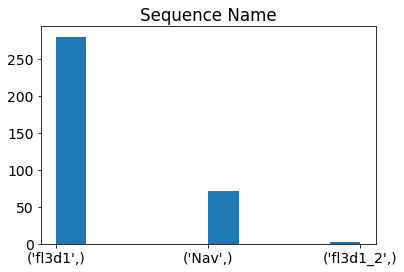

In [62]:
plt.rcParams.update({'font.size': 14})
plt.hist(df_unique['Sequence Name'].apply(lambda x: repr(tuple(x))).values)
plt.title('Sequence Name')
plt.show()

In [63]:
# df_unique[df_unique['Sequence Name'] == 'fl3d1']

In [64]:
# Inspect the null-values (e.g. for debugging)

# # Full dataset
# df_unique.applymap(lambda x: len(x) if np.all(pd.notnull(x)) else x)

# # Sequence-wise
# df_unique[df_unique['Sequence Name'] == 'Nav'].applymap(lambda x: len(x) if np.all(pd.notnull(x)) else x)

# # Columns with null-values (sequence-name-agnostic!)
# df_unique.columns[df_unique.applymap(lambda x: np.isnan(x) if not isinstance(x,np.ndarray) else False).any()]

## Sequence-specific analysis: choose sequence to analyze

In [65]:
analyzed_sequence = 'fl3d1'
df_unique_seq = df_unique[df_unique['Sequence Name'].apply(lambda x: x[0]) == analyzed_sequence]

# # Truncate columns for binary search of pathological column 
# df_unique_seq = df_unique_seq.drop(np.concatenate([df_unique_seq.columns.values[:76*len(df_unique_seq.columns.values)//128],df_unique_seq.columns.values[77*len(df_unique_seq.columns.values)//128:]]), axis=1)

### Here you can add columns of interest such as Trigger Time interval divided by heart cycle period (Nominal Interval) that will be plotted

In [66]:
def trigger_time_nominal_interval_ratio(row):
    trigger_time = row['Trigger Time']
    return (trigger_time.max()-trigger_time.min())/row['Nominal Interval'].mean()
    
if analyzed_sequence == 'fl3d1':
    df_unique_seq = pd.concat([df_unique_seq, pd.DataFrame({'Derived: Trigger Time range/Nominal Interval': df_unique_seq.apply(lambda x: np.array([trigger_time_nominal_interval_ratio(x)]),axis=1),
                                                            'Derived: Trigger Time Min': df_unique_seq.apply(lambda x: np.array([x['Trigger Time'].min()]),axis=1),
                                                            'Derived: Nominal Interval - Trigger Time Max': df_unique_seq.apply(lambda x: np.array([x['Nominal Interval'].mean() - x['Trigger Time'].max()]),axis=1),
                                                           })], axis=1)

### Display columns that will be discarded

In [67]:
# Visualize discarded columns computed from different conditions (can be altered) via set differences
if analyzed_sequence == 'Nav':
#     set_diff = set(df_unique_seq.columns[df_unique_seq.apply(lambda x: x.apply(lambda y: (isinstance(y,float) and np.isnan(y)) or (len(y) > 0 and isinstance(y[0],bytes)) or ( len(y) > 3 ) ), axis=1).any()].values) - \
#                set(df_unique_seq.columns[df_unique_seq.apply(lambda x: x.apply(lambda y: (isinstance(y,float) and np.isnan(y)) or ( len(y) > 3 ) ), axis=1).any()].values)
    set_diff = set(df_unique_seq.columns[df_unique_seq.apply(lambda x: x.apply(lambda y: (hasattr(y,'__len__') and len(y) > 5 ) ), axis=1).any()].values) - \
               set(df_unique_seq.columns[df_unique_seq.apply(lambda x: x.apply(lambda y: False ), axis=1).any()].values)
else:
#     set_diff = set(df_unique_seq.columns[df_unique_seq.apply(lambda x: x.apply(lambda y: (isinstance(y,float) and np.isnan(y)) or (len(y) > 0 and isinstance(y[0],bytes)) or ( len(y) >= np.min([*x['Cardiac Number of Images'],len(x['Slice Location'])]) ) ), axis=1).any()].values) - \
#                set(df_unique_seq.columns[df_unique_seq.apply(lambda x: x.apply(lambda y: (isinstance(y,float) and np.isnan(y)) or ( len(y) >= np.min([*x['Cardiac Number of Images'],len(x['Slice Location'])]) ) ), axis=1).any()].values)
    set_diff = set(df_unique_seq.columns[df_unique_seq.apply(lambda x: x.apply(lambda y: (hasattr(y,'__len__') and len(y) >= np.min([*x['Cardiac Number of Images'],len(x['Slice Location'])]) ) ), axis=1).any()].values) - \
               set(df_unique_seq.columns[df_unique_seq.apply(lambda x: x.apply(lambda y: False ), axis=1).any()].values)
df_unique_seq[ [el for el in set_diff] ]

[SlicePosition_PCS]  \
FileCollectionID Instance Creation Date Patient ID    Study Instance UID                                 Sequence Name Series Instance UID                                Image Type                                                                 
3                2009-03-23             ANONYM-REVX4  1.2.40.0.13.1.237828120959059386345548749032058... fl3d1         1.2.40.0.13.1.213723252275640155219987317546234... (ORIGINAL, PRIMARY) 0  [b'\x03\xcd\xc6\xce\x84_G\xc0\x8b=\x8b\x10D\xa...   
                                                                                                                       1.2.40.0.13.1.250363090365366252242767248776958... (ORIGINAL, PRIMARY) 0  [b'\xeex\x93\xdf\xa2\xb3\xe8?\x8e\xed\xce=\xb8...   
                 2011-06-25             ANONYM-KBPD3B 1.2.40.0.13.1.336917043524843706258805057826430... fl3d1         1.2.40.0.13.1.664971475135209300836943690831909... (ORIGINAL, PRIMARY) 0  [b'\xdc\x11-\xfdt\xe1\n\xc0\t!{\x18U\xa3b\xc0{...   
                                                                                                                       1.2.40.0.13.1.790954445771044222540324665337371... (ORIGINAL, PRIMARY) 0  [b'\x05\xec\x17\xaajpI\xc0\x05q7\xeb\xe0v`\xc0...   
4                2011-02-25             ANONYM-XB02NU 1.2.40.0.13.1.383247361281219639641420422715686... fl3d1         1.2.40.0.13.1.114078065755659861512876105881152... (ORIGINAL, PRIMARY) 0  [b'H\x80\x05\xf6\xb9z-\xc0\xee(\x8c5\x15\x06c\...   
...                                                                                                                                                                                                                                            ...   
147              2012-08-06             ANONYM-OLRSXE 1.2.40.0.13.1.185249453176344800882598111226180... fl3d1         1.2.40.0.13.1.273170922194323866512737254542749... (ORIGINAL, PRIMARY) 0  [b'\x98\xa3\xc7\xefmQ?\xc0\xa2\xf4"f\xb8l_\xc0...   
148              2013-06-11             ANONYM-JWJLSU 1.2.40.0.13.1.299106762787475685927449967090451... fl3d1         1.2.40.0.13.1.124363119240975454282317047061690... (ORIGINAL, PRIMARY) 0  [b'ca\x88\x9c\xbe\x9aF\xc0\xa1\x1eO\x893U_\xc0...   
                                                                                                                       1.2.40.0.13.1.224820703509406246127405111230565... (ORIGINAL, PRIMARY) 0  [b'/g\x9d\x8eS\xa6\xf9\xbfH|z\xae\xc7\x01b\xc0...   
149              2011-02-26             ANONYM-ZERI78 1.2.40.0.13.1.302616599070271638287565912761840... fl3d1         1.2.40.0.13.1.167498948539274632630921342391629... (ORIGINAL, PRIMARY) 0  [b'u\x81\xc3\xf2\x84\x85\x1f\xc0K\x94\x18_/!a\...   
                                                                                                                       1.2.40.0.13.1.334802931737932781838327577019930... (ORIGINAL, PRIMARY) 0  [b'W\x16\x1a\xc2\x10\xbd\xea\xbf~\xfd\x94S\xf0...   

                                                                                                                                                                                                                            Instance Creation Time  \
FileCollectionID Instance Creation Date Patient ID    Study Instance UID                                 Sequence Name Series Instance UID                                Image Type                                                                 
3                2009-03-23             ANONYM-REVX4  1.2.40.0.13.1.237828120959059386345548749032058... fl3d1         1.2.40.0.13.1.213723252275640155219987317546234... (ORIGINAL, PRIMARY) 0  [17:13:56.906000, 17:14:33.875000, 17:14:20.31...   
                                                                                                                       1.2.40.0.13.1.250363090365366252242767248776958... (ORIGINAL, PRIMARY) 0  [17:14:32.703000, 17:14:23.515000, 17:14:01.01...   
                 2011-06-25             

In [68]:
# Discard the above visualized columns
if analyzed_sequence == 'Nav':
    # Eliminate per-image varying information, bytes
#     df_unique_drop_columns = df_unique_seq.columns[df_unique_seq.apply(lambda x: x.apply(lambda y: (isinstance(y,float) and np.isnan(y)) or (len(y) > 0 and isinstance(y[0],bytes)) or ( len(y) > 3 ) ), axis=1).any()]
    df_unique_too_long_columns = df_unique_seq.columns[df_unique_seq.apply(lambda x: x.apply(lambda y: (hasattr(y,'__len__') and len(y) > 5 ) ), axis=1).any()]
else:
    # Eliminate spatio-temporal information
#     df_unique_drop_columns = df_unique_seq.columns[df_unique_seq.apply(lambda x: x.apply(lambda y: (isinstance(y,float) and np.isnan(y)) or (len(y) > 0 and isinstance(y[0],bytes)) or ( len(y) >= np.min([*x['Cardiac Number of Images'],len(x['Slice Location'])]) )  ), axis=1).any()]
    df_unique_too_long_columns = df_unique_seq.columns[df_unique_seq.apply(lambda x: x.apply(lambda y: (hasattr(y,'__len__') and len(y) >= np.min([*x['Cardiac Number of Images'],len(x['Slice Location'])]) )  ), axis=1).any()]
print("Dropping too long (spatio-temporal information in fl3d1) columns: {}".format(df_unique_too_long_columns))
df_unique_seq_sanitized = df_unique_seq.drop(df_unique_too_long_columns, axis=1)

# Choose sequence to visualize
df_unique_all_nan_empty_bytes_columns = df_unique_seq_sanitized.columns[df_unique_seq_sanitized.applymap(lambda x: (isinstance(x,float) and np.isnan(x)) or (hasattr(x,'__len__') and len(x) == 0) or (len(x) > 0 and isinstance(x[0],bytes)) ).all()]
print("Dropping all-NaN/empty/bytes columns: {}".format(df_unique_all_nan_empty_bytes_columns))
df_unique_plot = df_unique_seq_sanitized.drop(df_unique_all_nan_empty_bytes_columns, axis=1)
# df_unique_plot = df_unique_seq_sanitized.drop(df_unique_seq_sanitized.columns[df_unique_seq_sanitized.applymap(lambda x: len(x) == 0).all()], axis=1)


Dropping too long (spatio-temporal information in fl3d1) columns: Index(['Instance Creation Time', 'SOP Instance UID', 'Acquisition Time',
       'Content Time', 'Trigger Time', '[SlicePosition_PCS]',
       'Instance Number', 'Image Position (Patient)', 'Slice Location',
       'Smallest Image Pixel Value', 'Largest Image Pixel Value',
       'Window Center', 'Window Width'],
      dtype='object')
Dropping all-NaN/empty/bytes columns: Index(['Inversion Time', 'Contrast Flow Duration',
       '[SliceMeasurementDuration]', '[ImaRelTablePosition]',
       '[SliceResolution]', 'Overlay Rows', 'Overlay Columns', 'Overlay Type',
       'Overlay Origin', 'Overlay Bits Allocated', 'Overlay Bit Position',
       '[RealDwellTime]', 'Institution Name', 'Institution Address',
       'Station Name', 'Study Description', 'Series Description',
       'Institutional Department Name',
       'Referenced Performed Procedure Step Sequence',
       'Derivation Description', 'Issuer of Patient ID', 'Other

### Perform visualization (incl. some final type conversions)

In [69]:
plt.rcParams.update({'font.size': 18})

# Show non-unique tags
print("Columns with multiple values (treated as stacked): {}.".format(df_unique_plot.columns[df_unique_plot.applymap(lambda x: hasattr(x,'__len__') and len(x) > 1).any()]))

# # df_unique_plot_repr = df_unique_plot.apply(lambda x: x.apply(lambda y: y[0]) if x.apply(lambda y: len(y) == 1).all() else x.apply(lambda y: tuple(y)) )
# tuple_with_newlines = lambda x : x if not isinstance(x,tuple) else '(' + ',\n'.join([str(el) for el in x]) + ')'
# df_unique_plot_repr = df_unique_plot.apply(lambda x: x.apply(lambda y: tuple_with_newlines(y[0])) if x.apply(lambda y: len(y) == 1).all() else x.apply(lambda y: tuple([tuple_with_newlines(el) for el in y])) )

# num_columns = len(df_unique_plot_repr.columns)
num_columns = len(df_unique_plot.columns)
ncols=4
nrows=(num_columns+ncols-1)//ncols
fig, ax = plt.subplots(nrows=nrows , ncols=ncols, figsize=(12*ncols,20*nrows))
axs = ax.flatten()

# for i, col in enumerate(df_unique_plot_repr.columns[:num_columns]):
for i, col in enumerate(df_unique_plot.columns[:num_columns]):
    
    # Filter any left over NaNs
    df_unique_plot_is_not_nan = df_unique_plot[col].apply(lambda y: not( (isinstance(y,float) and np.isnan(y)) ) )
    df_unique_plot_col = df_unique_plot[col][df_unique_plot_is_not_nan]
    
    def get_tuple_type(el):
        if not isinstance(el,(tuple,list,np.ndarray)):
            return type(el)
        else:
            return tuple([get_tuple_type(el_i) for el_i in el])
            
#     value_types = df_unique_plot_repr[col].apply(type).values
    value_types = set()
    for t in df_unique_plot_col.apply(lambda x: get_tuple_type(x) ).unique(): # unique types across series
        # print("Value type: {}".format(t), flush=True)
        for t_i in t: # unique types within series
            value_types.add(t_i)
    print("Plotting {}".format(col))
    print("    value types: {}".format(value_types), flush=True)
    if len(value_types) > 1:
        print("WARNING: column {} with heterogeneous value types: {}".format(col, value_types), flush=True)

    def get_plot_value(col, series_value, value_types):
        if isinstance(series_value,tuple):
            return  '(' + ',\n'.join([str(el) for el in series_value]) + ')'
        elif col == 'Patient\'s Age':
            assert isinstance(series_value, str)
            return int( re.search(r'^(?P<age>\d{3})Y$', series_value).group('age') )
        elif col == 'Patient\'s Sex':
            return series_value if series_value != 'W' else 'F'
        elif isinstance(series_value, datetime.date):
            if len(value_types) == 1:
                return mdates.date2num(series_value)
            else: # str is fallback representation
                return str(series_value)                
        elif isinstance(series_value, datetime.time):
            if len(value_types) == 1:
                return mdates.date2num(datetime.datetime(1900,1,1,
                                                     series_value.hour, series_value.minute, series_value.second, 
                                                     series_value.microsecond, series_value.tzinfo))
            else: # str is fallback representation
                return str(series_value)                
        elif isinstance(series_value, pydicom.valuerep.PersonName): # or col == 'Rescale Type':
            return str(series_value)
        elif isinstance(series_value, str) or np.isscalar(series_value):
            return series_value
        else:
            raise ValueError("No treatment for {} of type {}".format(series_value, type(series_value)))

    # Distinguish all single-valued from multi-valued columns
    if df_unique_plot_col.apply(lambda y: len(y) == 1).all():
        df_unique_plot_col_finished = df_unique_plot_col.apply(lambda x: get_plot_value(col, x[0], value_types)) # newlines are rather for tick labels
    else:
        df_unique_plot_col_finished = df_unique_plot_col.apply(lambda x: tuple([ get_plot_value(col, x_i, value_types) for x_i in x])) # newlines are rather for tick labels
        if df_unique_plot_col_finished.apply(lambda y: len(y) == 0).any(): # e.g. needed if col == 'Rescale Type':
            df_unique_plot_col_finished = df_unique_plot_col_finished.apply(repr)

    axs[i].hist(df_unique_plot_col_finished.values, label=col, bins=30, stacked=True)
    
    if datetime.date in value_types and len(value_types) == 1:
#         axs[i].xaxis.set_major_locator(mdates.YearLocator())
#         axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y'))
        locator = mdates.AutoDateLocator()
        axs[i].xaxis.set_major_locator(locator)
        axs[i].xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
    elif datetime.time in value_types and len(value_types) == 1:
        axs[i].xaxis.set_major_locator(mdates.HourLocator())
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        
    
#     if col != 'Rescale Type':
#         axs[i].hist(df_unique_plot_col_finished.values, label=col, bins=30, stacked=True)
#     else:
#         axs[i].hist(df_unique_plot_col_finished.apply(repr).values, label=col, bins=30, stacked=True)
        

    
#     if len(value_types) == 1:
#         if isinstance(list(value_types)[0],tuple): # maybe this can also handle situations with multiple values per series, each being a tuple
#             axs[i].hist(df_unique_plot_col.apply(lambda y: '(' + ',\n'.join([str(el) for el in y[0]]) + ')').values , label=col, bins=30, stacked=True)            
#         elif not(datetime.time in value_types or datetime.date in value_types or pydicom.valuerep.PersonName in value_types or col == 'Rescale Type' ):
#             axs[i].hist(df_unique_plot_col.values, label=col, bins=30, stacked=True)
#         else:
#             axs[i].hist(df_unique_plot_col.apply(str).values, label=col, bins=30, stacked=True)
#     else:
#         print("Column {} with heterogeneous value types: {}".format(col, value_types), flush=True)
#         axs[i].hist(df_unique_plot_col.values, label=col, bins=30, stacked=True)
        

#     if not(datetime.time in value_types or datetime.date in value_types or pydicom.valuerep.PersonName in value_types or col == 'Rescale Type' ):
#         axs[i].hist(df_unique_plot_repr[col].values, label=col, bins=30, stacked=True)
#     else:
#         axs[i].hist(df_unique_plot_repr[col].apply(str).values, label=col, bins=30, stacked=True)
# #         axs[i].hist(df_unique_plot_repr.apply(lambda x: datetime.datetime(x[col[:-4]+"Date"].year, x[col[:-4]+"Date"].month, x[col[:-4]+"Date"].day, x[col].hour, x[col].minute, x[col].second, x[col].microsecond), axis=1).values, label=col, bins=30, stacked=True)        

    title_num_nans = (~df_unique_plot_is_not_nan).sum()
    title_num_rows = df_unique_plot_is_not_nan.shape[0]
    title_addendum = " ({}/{} NaNs excluded)".format(title_num_nans, title_num_rows) if title_num_nans != 0 else ""
    axs[i].set_title(col + title_addendum) # could also add value_types if desired
    axs[i].tick_params(labelrotation=90)

fig.tight_layout()

Columns with multiple values (treated as stacked): Index(['Nominal Interval'], dtype='object').
Plotting Specific Character Set
    value types: {<class 'str'>}
Plotting Image Type
    value types: {(<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>)}
Plotting Instance Creation Date
    value types: {<class 'datetime.date'>}
Plotting SOP Class UID
    value types: {<class 'str'>}
Plotting Study Date
    value types: {<class 'datetime.date'>}
Plotting Series Date
    value types: {<class 'datetime.date'>}
Plotting Content Date
    value types: {<class 'datetime.date'>}
Plotting Study Time
    value types: {<class 'datetime.time'>}
Plotting Series Time
    value types: {<class 'datetime.time'>}
Plotting Accession Number
    value types: {<class 'str'>}
Plotting Issuer of Accession Number Sequence
    value types: {((<class 'str'>,),)}
Plotting Modality
    value types: {<class 'str'>}
Plotting Manufacturer
    value types: {<class 'str'>}
Plotting Referring Physician's Name
    